# 공기압축기 이상탐지 프로젝트

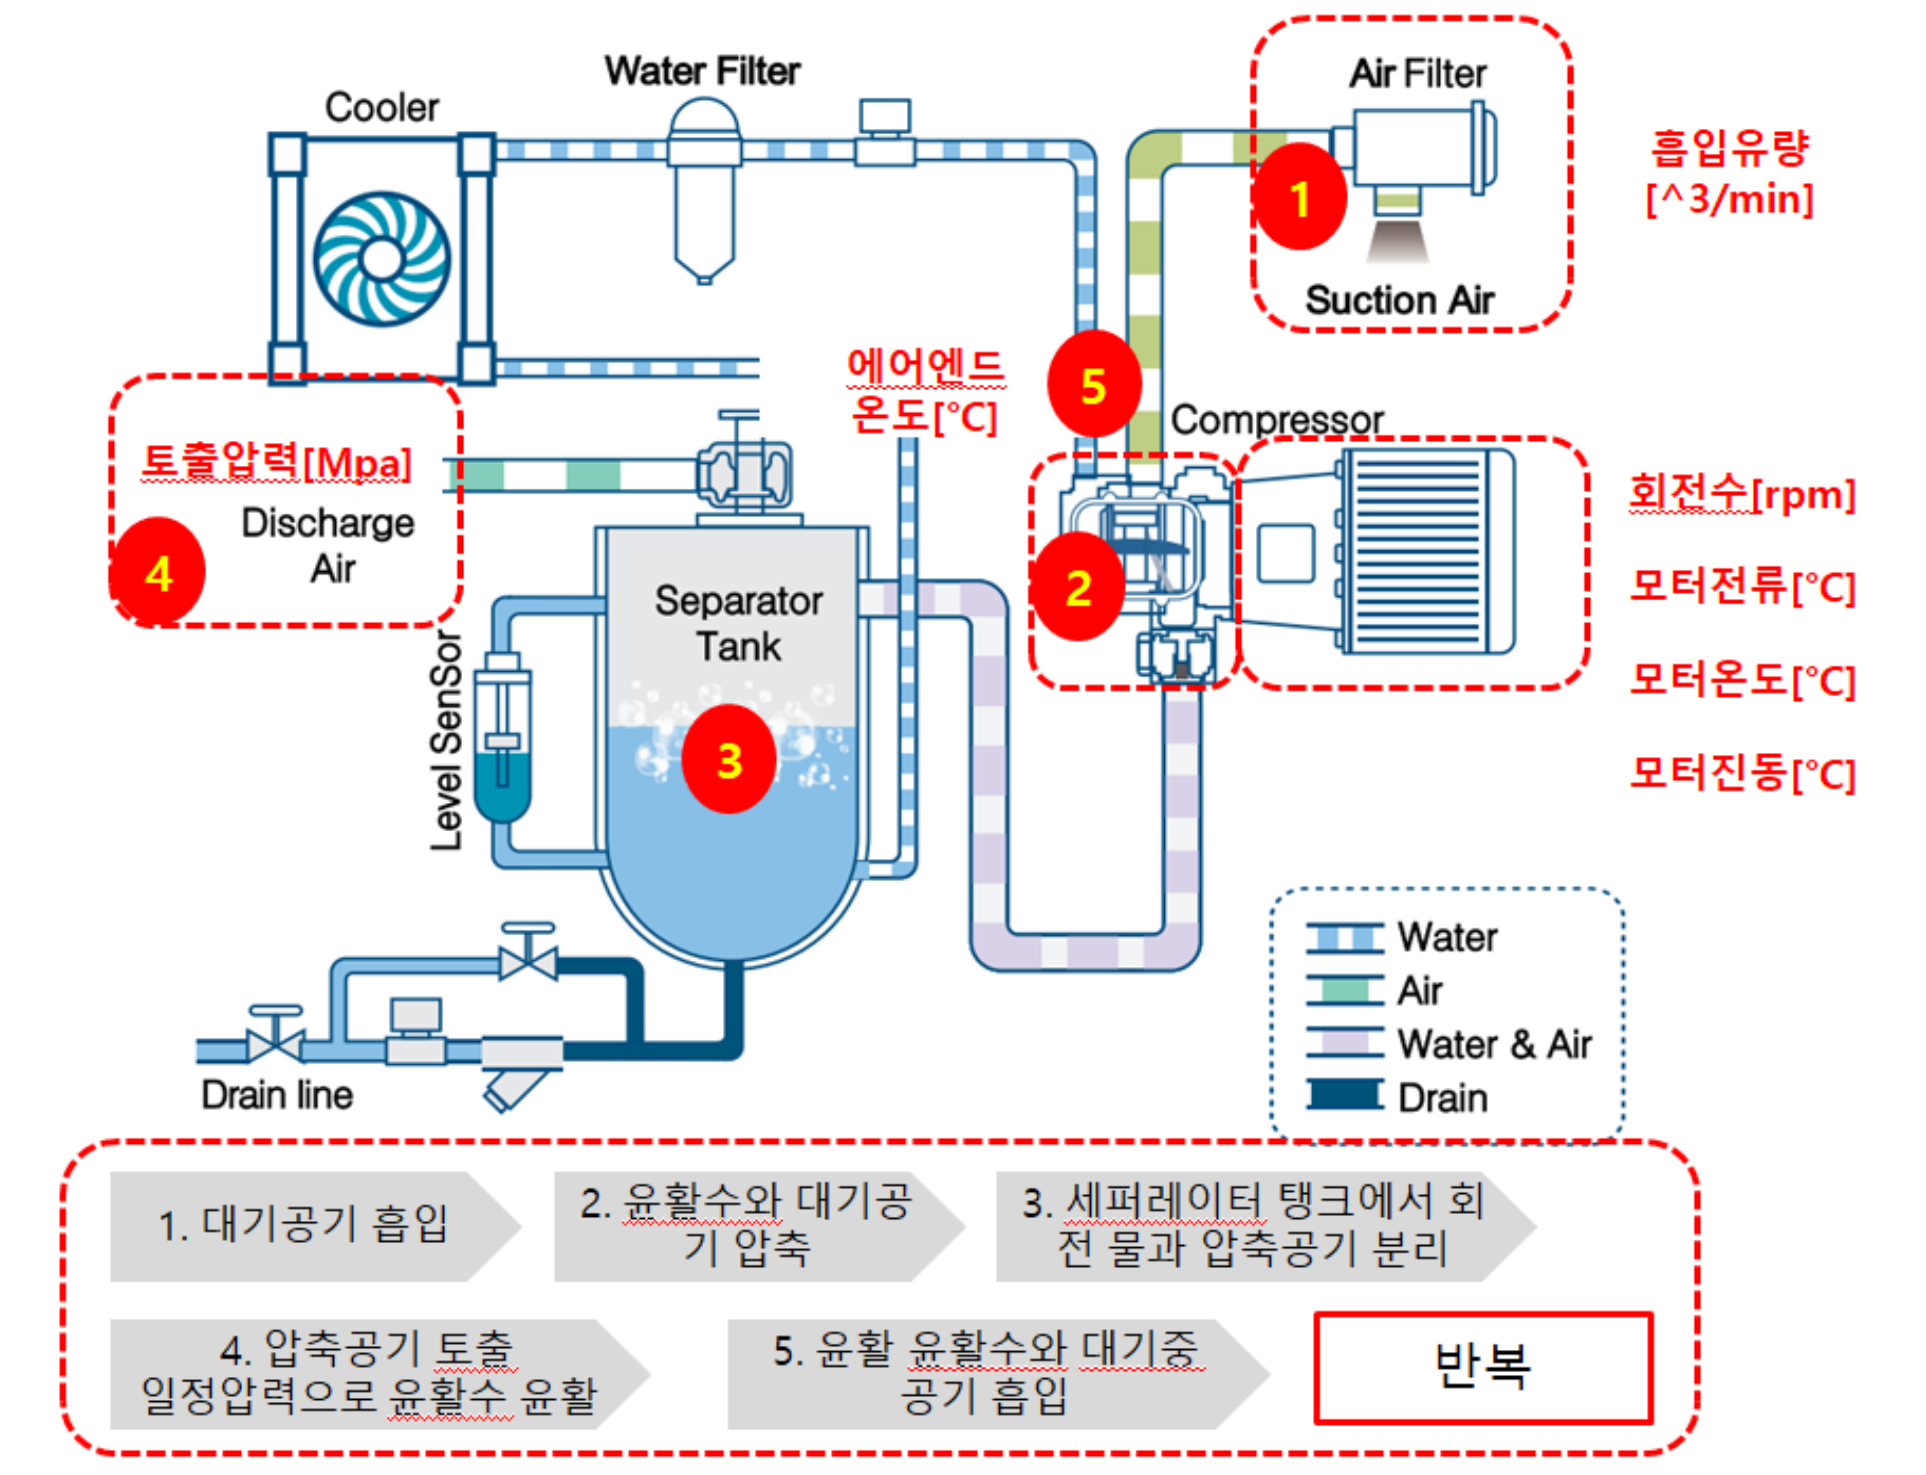

---
1. 데이터 구성 항목은 다음과 같습니다.   
- air_inflow: 공기 흡입 유량 (^3/min)   
- air_end_temp: 공기 말단 온도 (°C)   
- out_pressure: 토출 압력 (Mpa)   
- motor_current: 모터 전류 (A)   
- motor_rpm: 모터 회전수 (rpm)   
- motor_temp: 모터 온도 (°C)   
- motor_vibe: 모터 진동 (mm/s)   
- type: 설비 번호   

2. 또한 설비별로 다음의 특성을 갖습니다.   
- 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)   
- 설비 번호 1: 20HP   
- 설비 번호 2: 10HP   
- 설비 번호 3: 50HP   

3. 제출양식   
0(정상) 또는 1(이상)

---
- train_data: 학습용 데이터로 모두 **정상 case**로 이루어진 데이터입니다.
- test_data: 평가용 데이터로 정상 case와 이상 case가 함께 포함되어 있는 데이터로, 예측 대상에 해당됩니다.
- answer_sample: test_data에 대하여 작성할 제출용 레이블 파일 양식입니다.

## 패키지 로드

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

In [2]:
train_data = pd.read_csv("./dataset/train_data.csv")
train_data

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0           1.59         41.00           0.7          20.53     1680.0   
1           2.97         59.28           0.7          38.40     3142.0   
2           1.91         45.29           0.7          24.73     2023.0   
3           2.37         51.33           0.7          30.63     2506.0   
4           1.90         45.21           0.7          24.65     2017.0   
...          ...           ...           ...            ...        ...   
2458        2.28         50.20           0.7          29.53     2416.0   
2459        2.04         46.94           0.7          26.34     2155.0   
2460        1.19         35.74           0.7          15.39     1259.0   
2461        1.21         36.00           0.7          15.64     1280.0   
2462        2.72         55.99           0.7          35.19     2879.0   

      motor_temp  motor_vibe  type  
0          58.67        2.93     0  
1          74.91        3.75     0  
2          62.48        3.12     0  
3          67.84        3.39     0  
4          62.41        3.12     0  
...          ...         ...   ...  
2458       66.84        3.34     7  
2459       63.94        3.20     7  
2460       53.99        2.70     7  
2461       54.22        2.71     7  
2462       71.99        3.60     7  

[2463 rows x 8 columns]

In [3]:
test_data=pd.read_csv("./dataset/test_data.csv")
test_data

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0           2.51         53.28           0.7          32.54     2662.0   
1           2.66         55.24           0.7          34.45     2819.0   
2           1.72         42.74           0.7          22.23     1819.0   
3           2.20         49.15           0.7          28.50     2332.0   
4           2.06         47.28           0.7          26.67     2182.0   
...          ...           ...           ...            ...        ...   
7384        2.12         48.08           0.7          27.45     2246.0   
7385        1.48         39.63           0.7          19.19     1570.0   
7386        1.56         40.61           0.7          20.15     1649.0   
7387        1.59         40.99           0.7          20.52     1679.0   
7388        1.70         42.51           0.7          22.01     1801.0   

      motor_temp  motor_vibe  type  
0          69.58        3.48     0  
1          71.32        3.57     0  
2          60.21        3.01     0  
3          65.91        3.30     0  
4          64.24        3.21     0  
...          ...         ...   ...  
7384       64.96        3.25     7  
7385       57.44        2.87     7  
7386       58.32        2.92     7  
7387       58.66        2.93     7  
7388       60.01        3.00     7  

[7389 rows x 8 columns]

2. 또한 설비별로 다음의 특성을 갖습니다.   
- 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)   
- 설비 번호 1: 20HP   
- 설비 번호 2: 10HP   
- 설비 번호 3: 50HP   


In [4]:
# 마력 컬럼 추가
train_data.loc[train_data[train_data.type == 1].index, "hp"] = 20
train_data.loc[train_data[train_data.type == 2].index, "hp"] = 10
train_data.loc[train_data[train_data.type == 3].index, "hp"] = 50
train_data.hp.fillna(30, inplace=True)

test_data.loc[test_data[test_data.type == 1].index, "hp"] = 20
test_data.loc[test_data[test_data.type == 2].index, "hp"] = 10
test_data.loc[test_data[test_data.type == 3].index, "hp"] = 50
test_data.hp.fillna(30, inplace=True)

In [5]:
new_column = ['out_pressure', 'air_inflow', 'air_end_temp', 'motor_current',
       'motor_rpm', 'motor_temp', 'motor_vibe', 'type', 'hp']

train_data = train_data[new_column]
test_data = test_data[new_column]

## EDA

### 히스토그램 파악

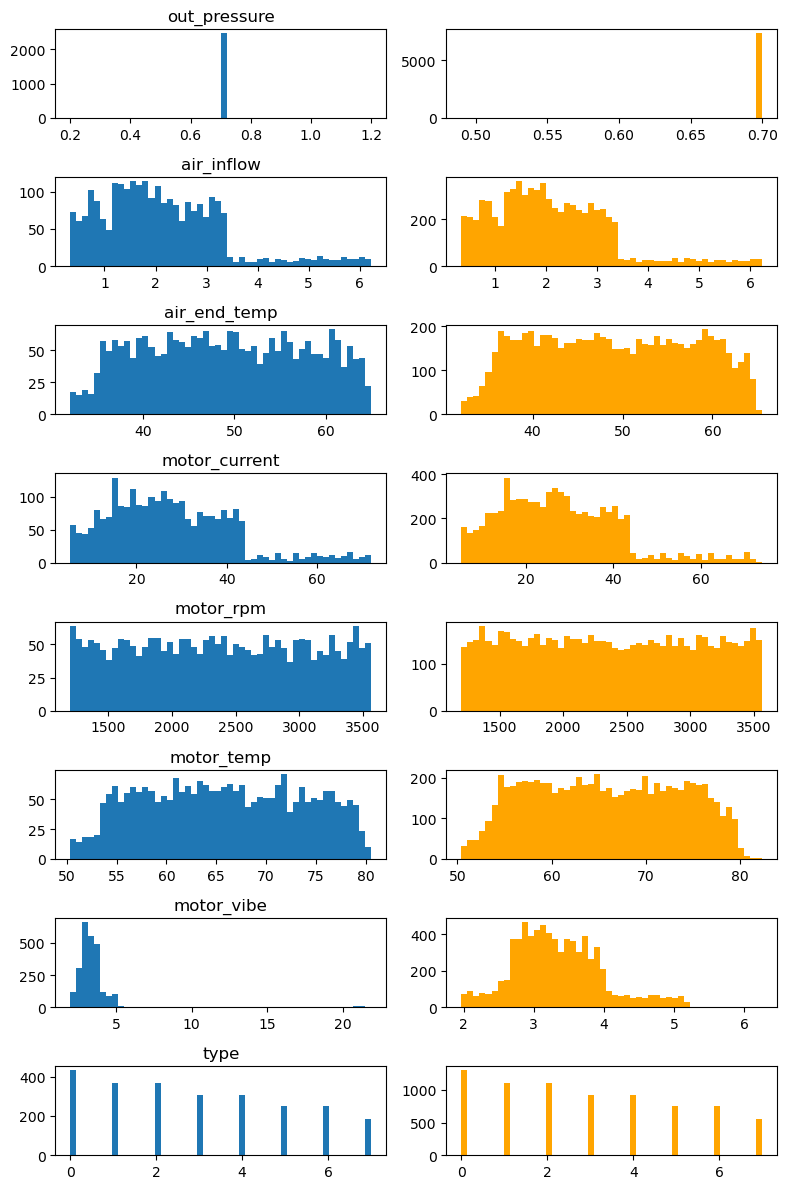

In [6]:
fig, axes = plt.subplots(8, 2, figsize=(8,12))
for i, col in enumerate(train_data.columns[:-1]):
    axes[i][0].hist(train_data[col], bins=50)
    axes[i][1].hist(test_data[col], bins=50, color='orange')
    axes[i][0].set_title(col)
fig.tight_layout()    
plt.show()

### 타입별 히스토그램

#### Type 0

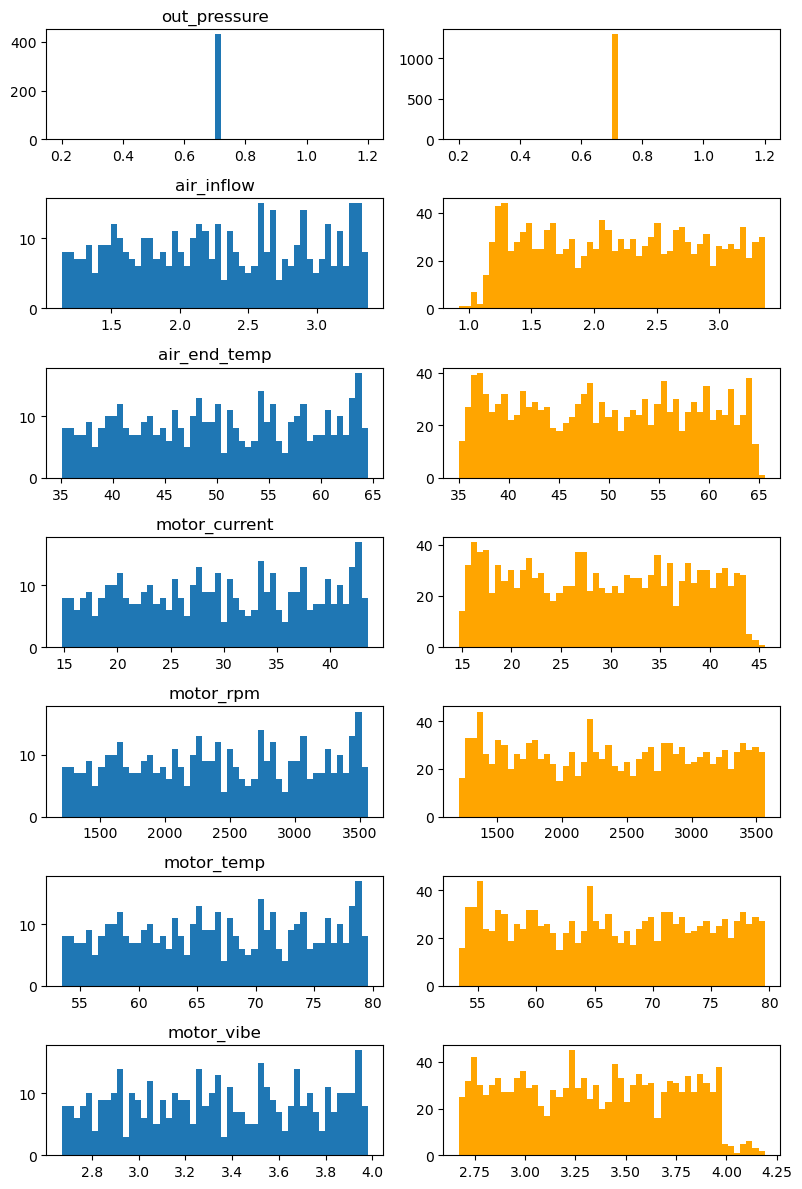

In [7]:
train0 = train_data[train_data.type == 0]
test0 = test_data[test_data.type == 0]

def plot_hist_all(train, test):
    fig, axes = plt.subplots(len(train.columns)-2, 2, figsize=(8,12))
    for i, col in enumerate(train.columns[:-2]):
        axes[i][0].hist(train[col], bins=50)
        axes[i][1].hist(test[col], bins=50, color='orange')
        axes[i][0].set_title(col)
    fig.tight_layout()    
    plt.show()
    
plot_hist_all(train0, test0)

#### Type 1

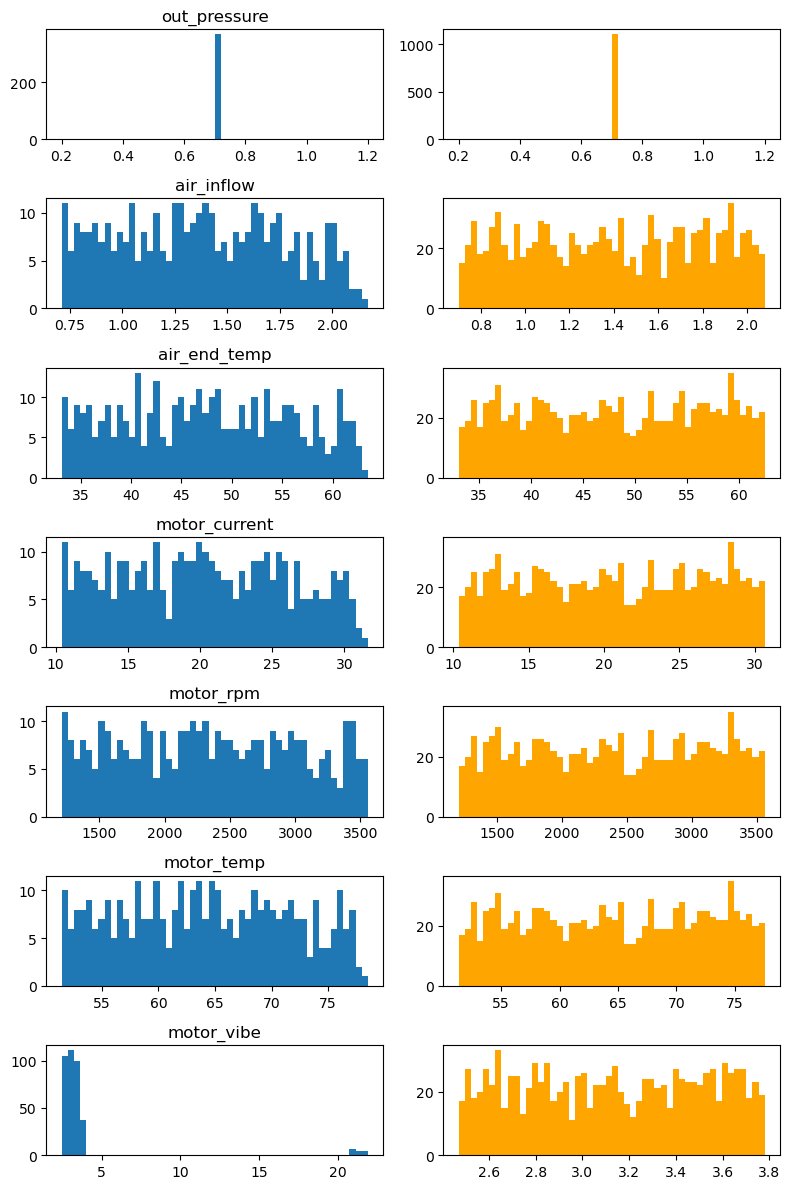

In [8]:
train1 = train_data[train_data.type == 1]
test1 = test_data[test_data.type == 1]

plot_hist_all(train1, test1)

#### Type 2

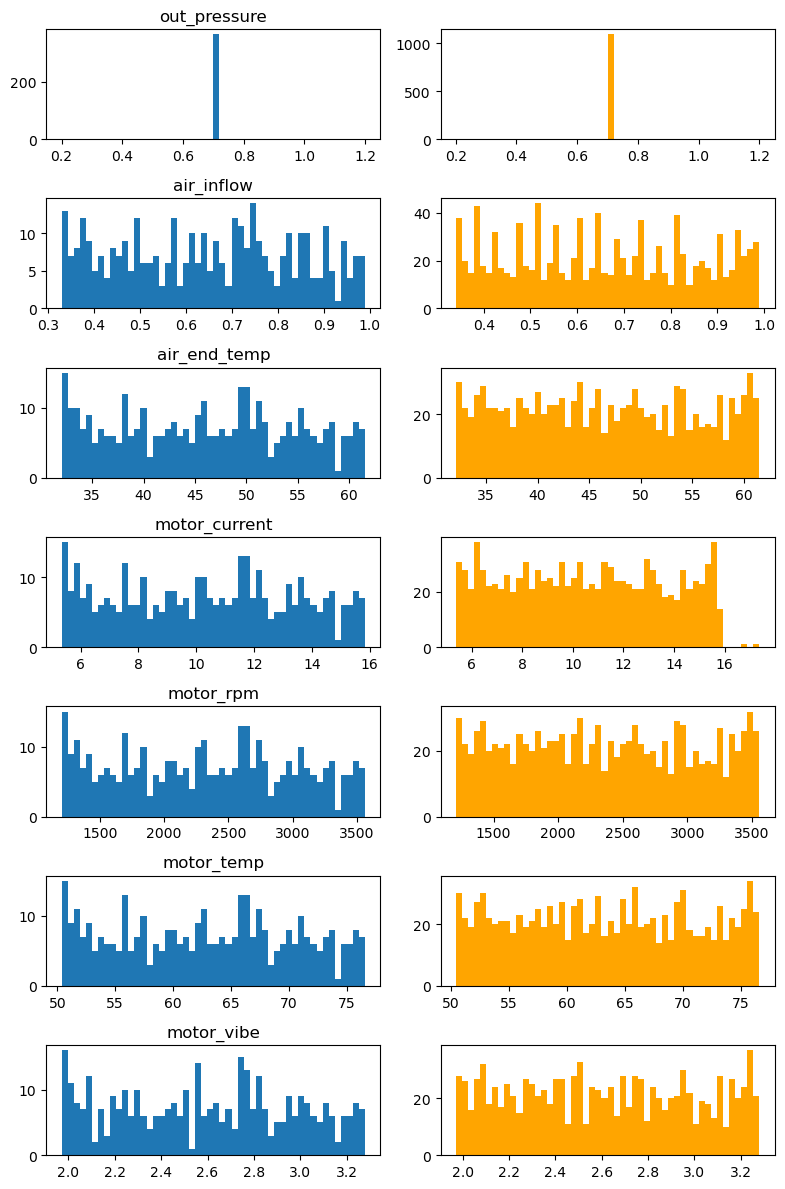

In [9]:
train2 = train_data[train_data.type == 2]
test2 = test_data[test_data.type == 2]

plot_hist_all(train2, test2)

#### Type 3

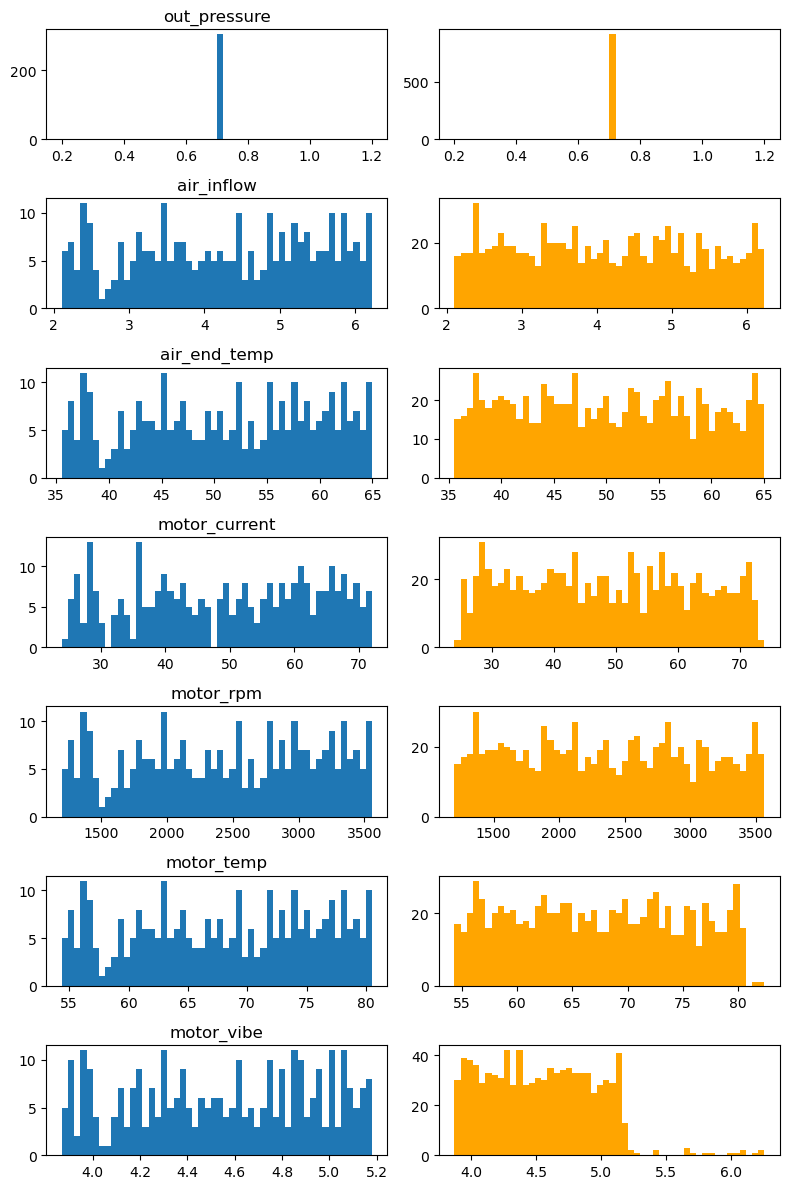

In [10]:
train3 = train_data[train_data.type == 3]
test3 = test_data[test_data.type == 3]

plot_hist_all(train3, test3)

#### Type 4


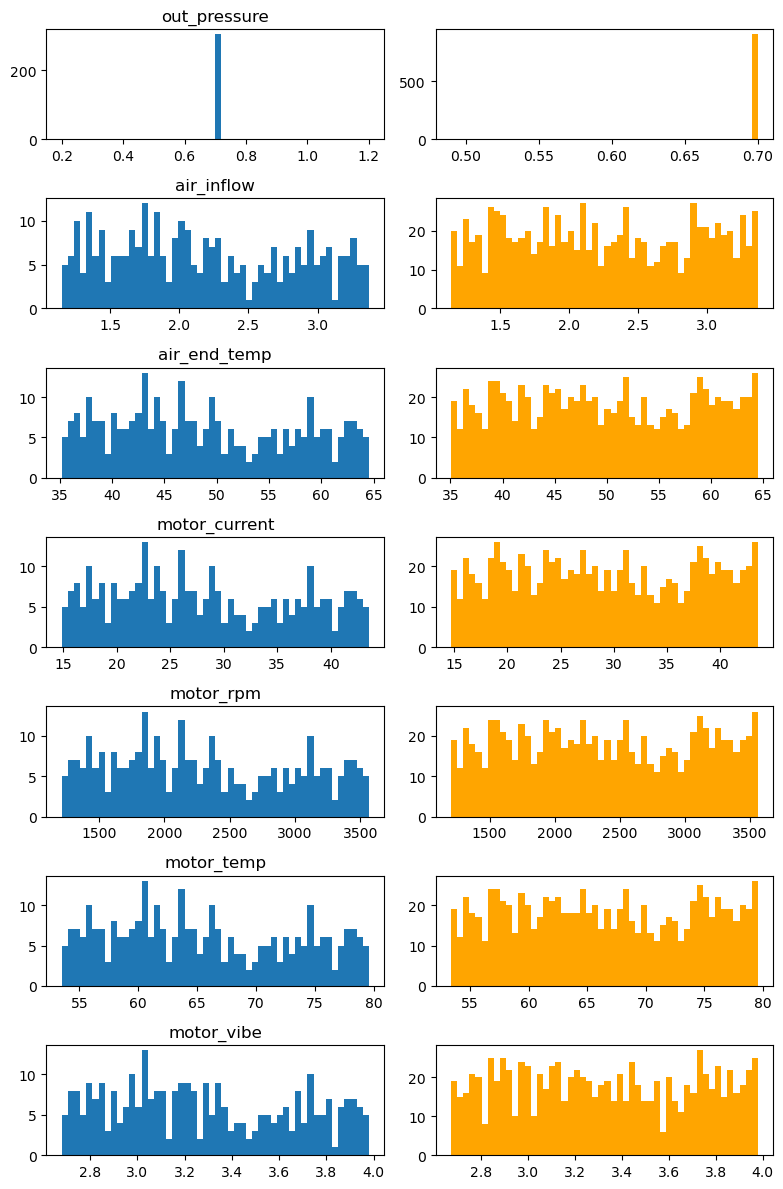

In [11]:
train4 = train_data[train_data.type == 4]
test4 = test_data[test_data.type == 4]

plot_hist_all(train4, test4)

#### Type 5

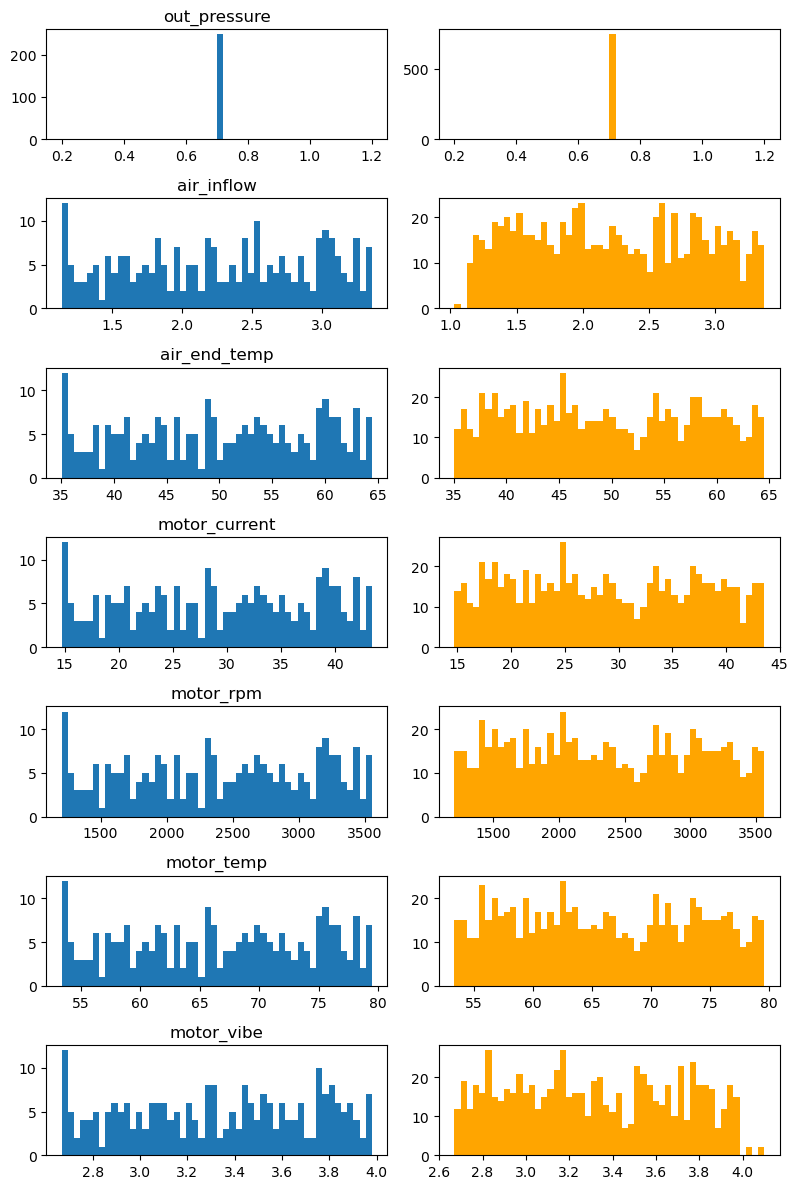

In [12]:
train5 = train_data[train_data.type == 5]
test5 = test_data[test_data.type == 5]

plot_hist_all(train5, test5)

#### Type 6

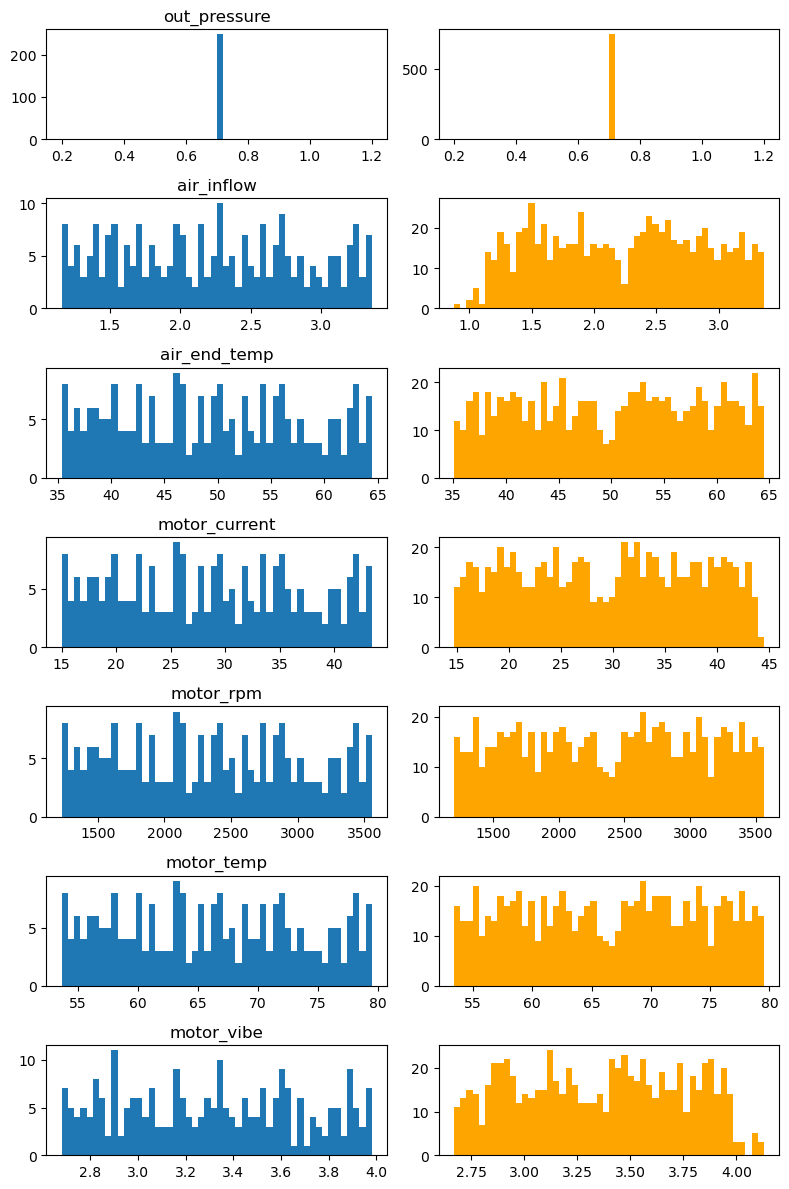

In [13]:
train6 = train_data[train_data.type == 6]
test6 = test_data[test_data.type == 6]

plot_hist_all(train6, test6)

#### Type 7

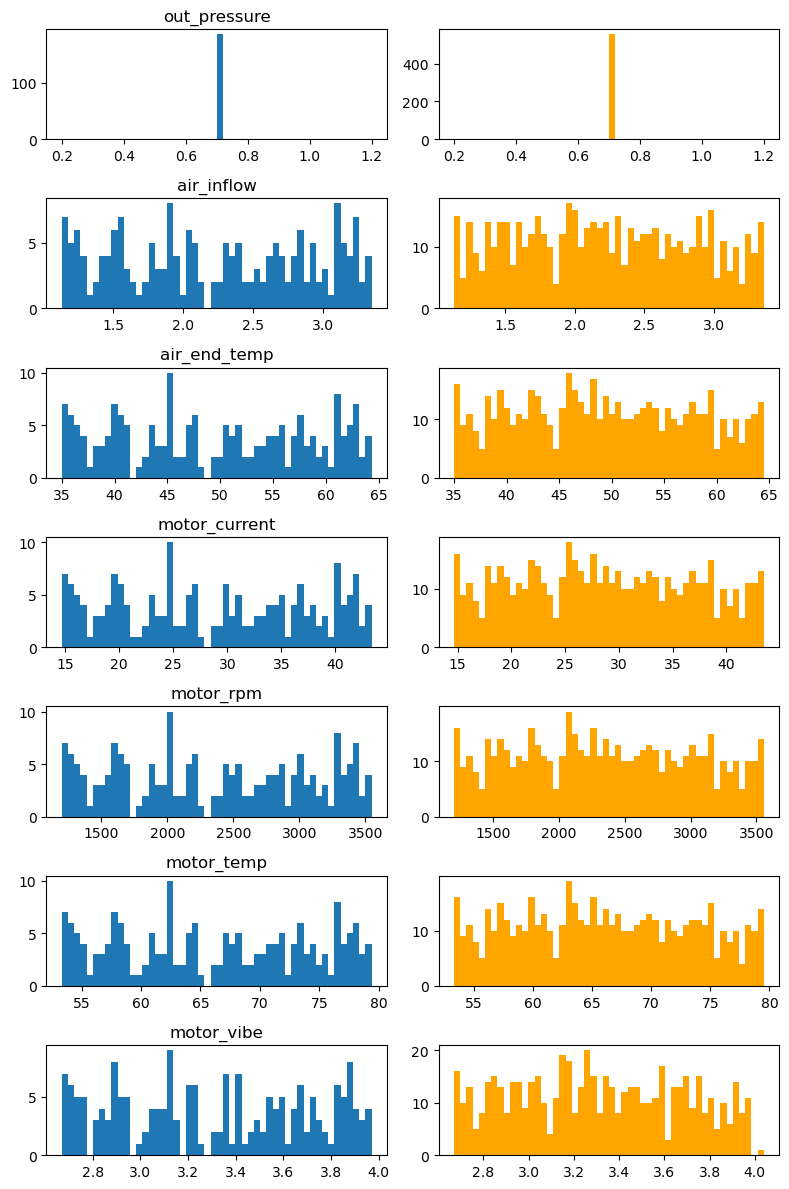

In [14]:
train7 = train_data[train_data.type == 7]
test7 = test_data[test_data.type == 7]

plot_hist_all(train7, test7)

#### 30마력

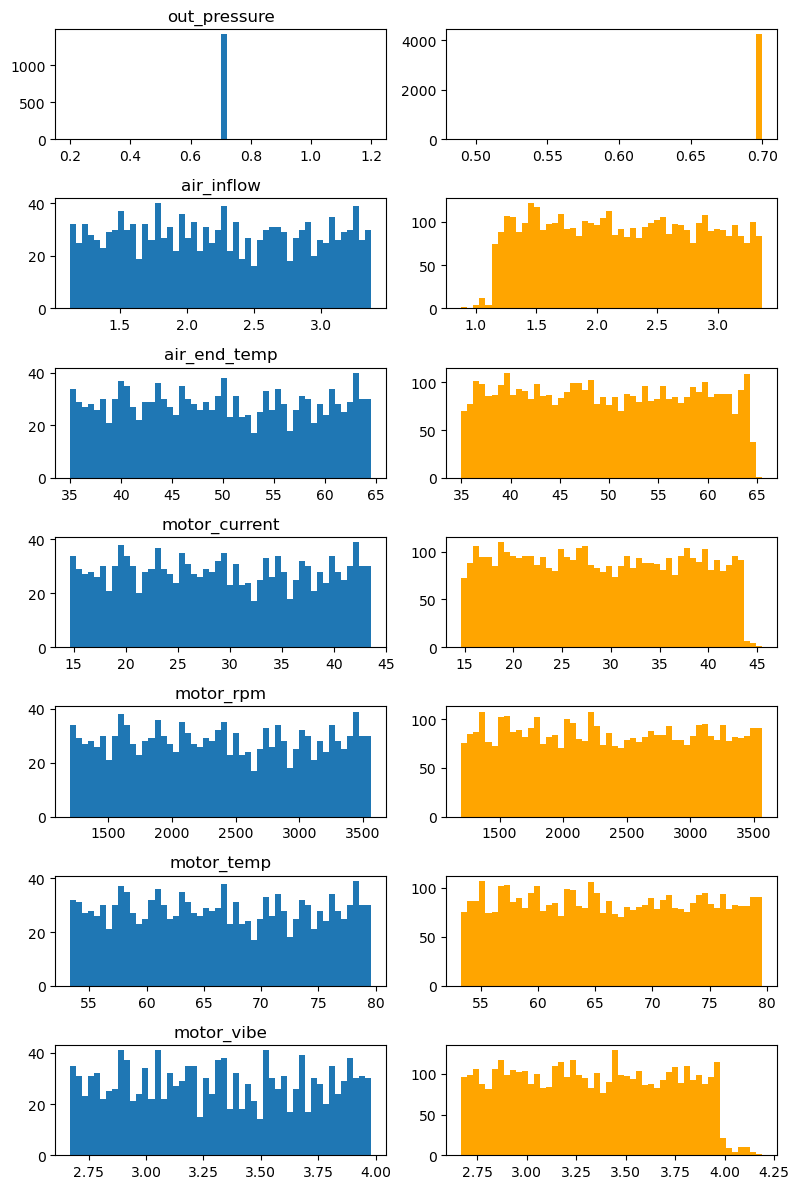

In [15]:
train_30 = train_data[train_data.hp == 30]
test_30 = test_data[test_data.hp == 30]

plot_hist_all(train_30, test_30)

### OutPressure가 0.7이 아닌 경우

In [16]:
outlier_pressure = test_data[test_data.out_pressure != 0.7].index
outlier_pressure

Int64Index([4917, 4918, 4919, 4920, 4921, 4922, 4923], dtype='int64')

### TSNE 시각화

In [17]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=1234)
# temp = tsne.fit_transform(train_data.iloc[:,:-2])

# tsne_df = pd.DataFrame(temp, columns=['x', 'y'])
# tsne_df['type'] = train_data.type

# sns.set_palette('deep')
# plt.figure(figsize=(14,10))
# sns.scatterplot(x='x', y='y', hue='type', data=tsne_df)

### 상관관계

#### pair plot

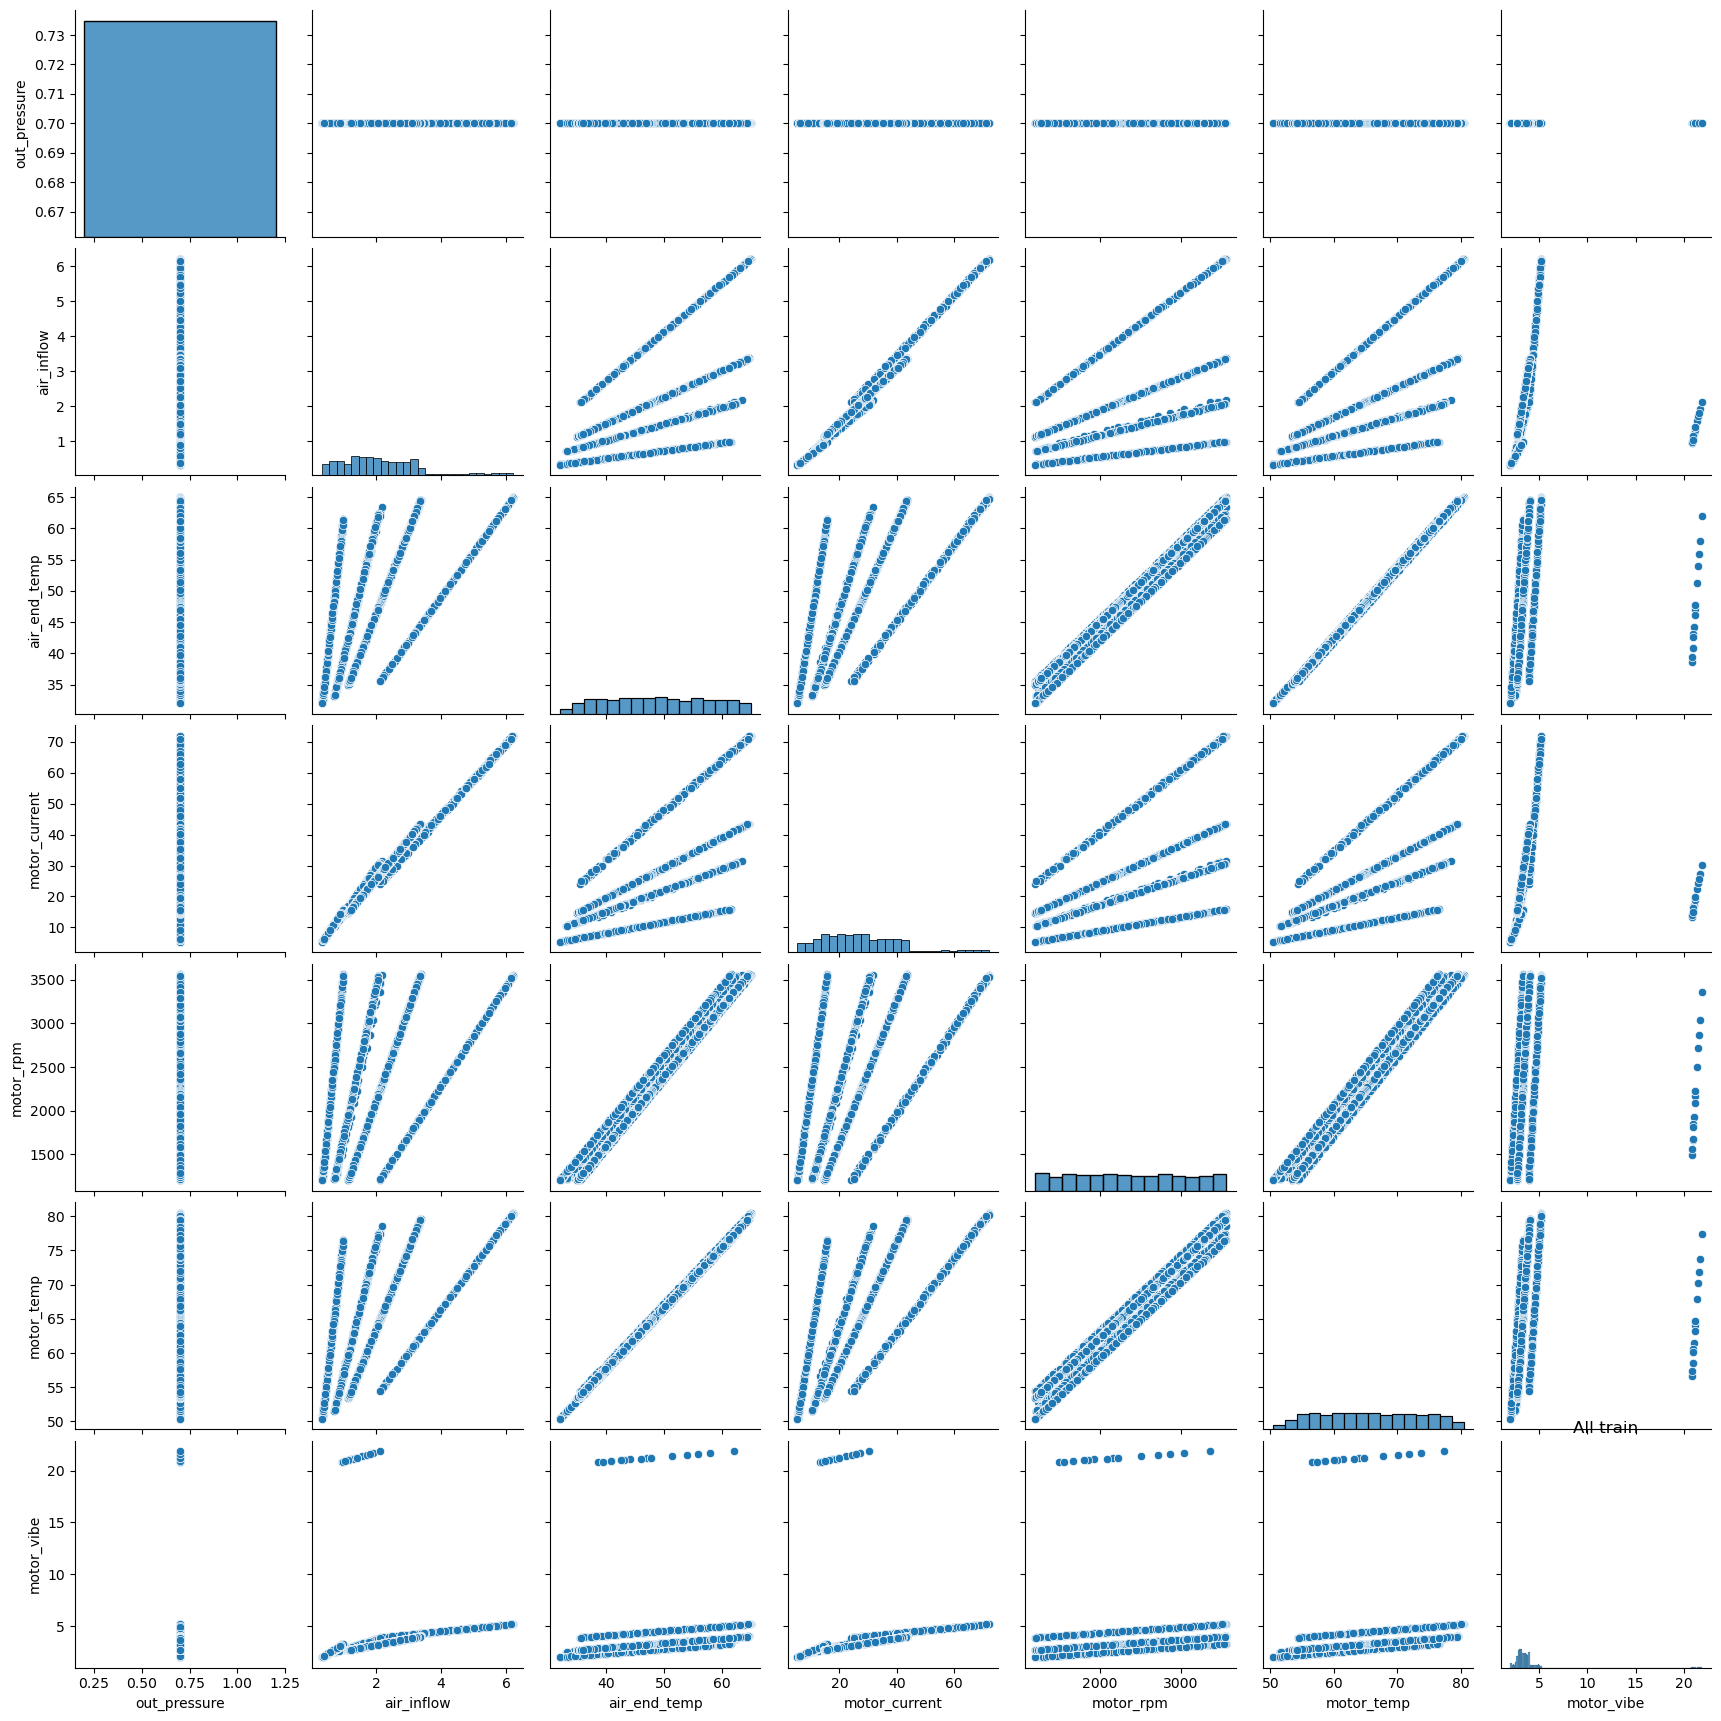

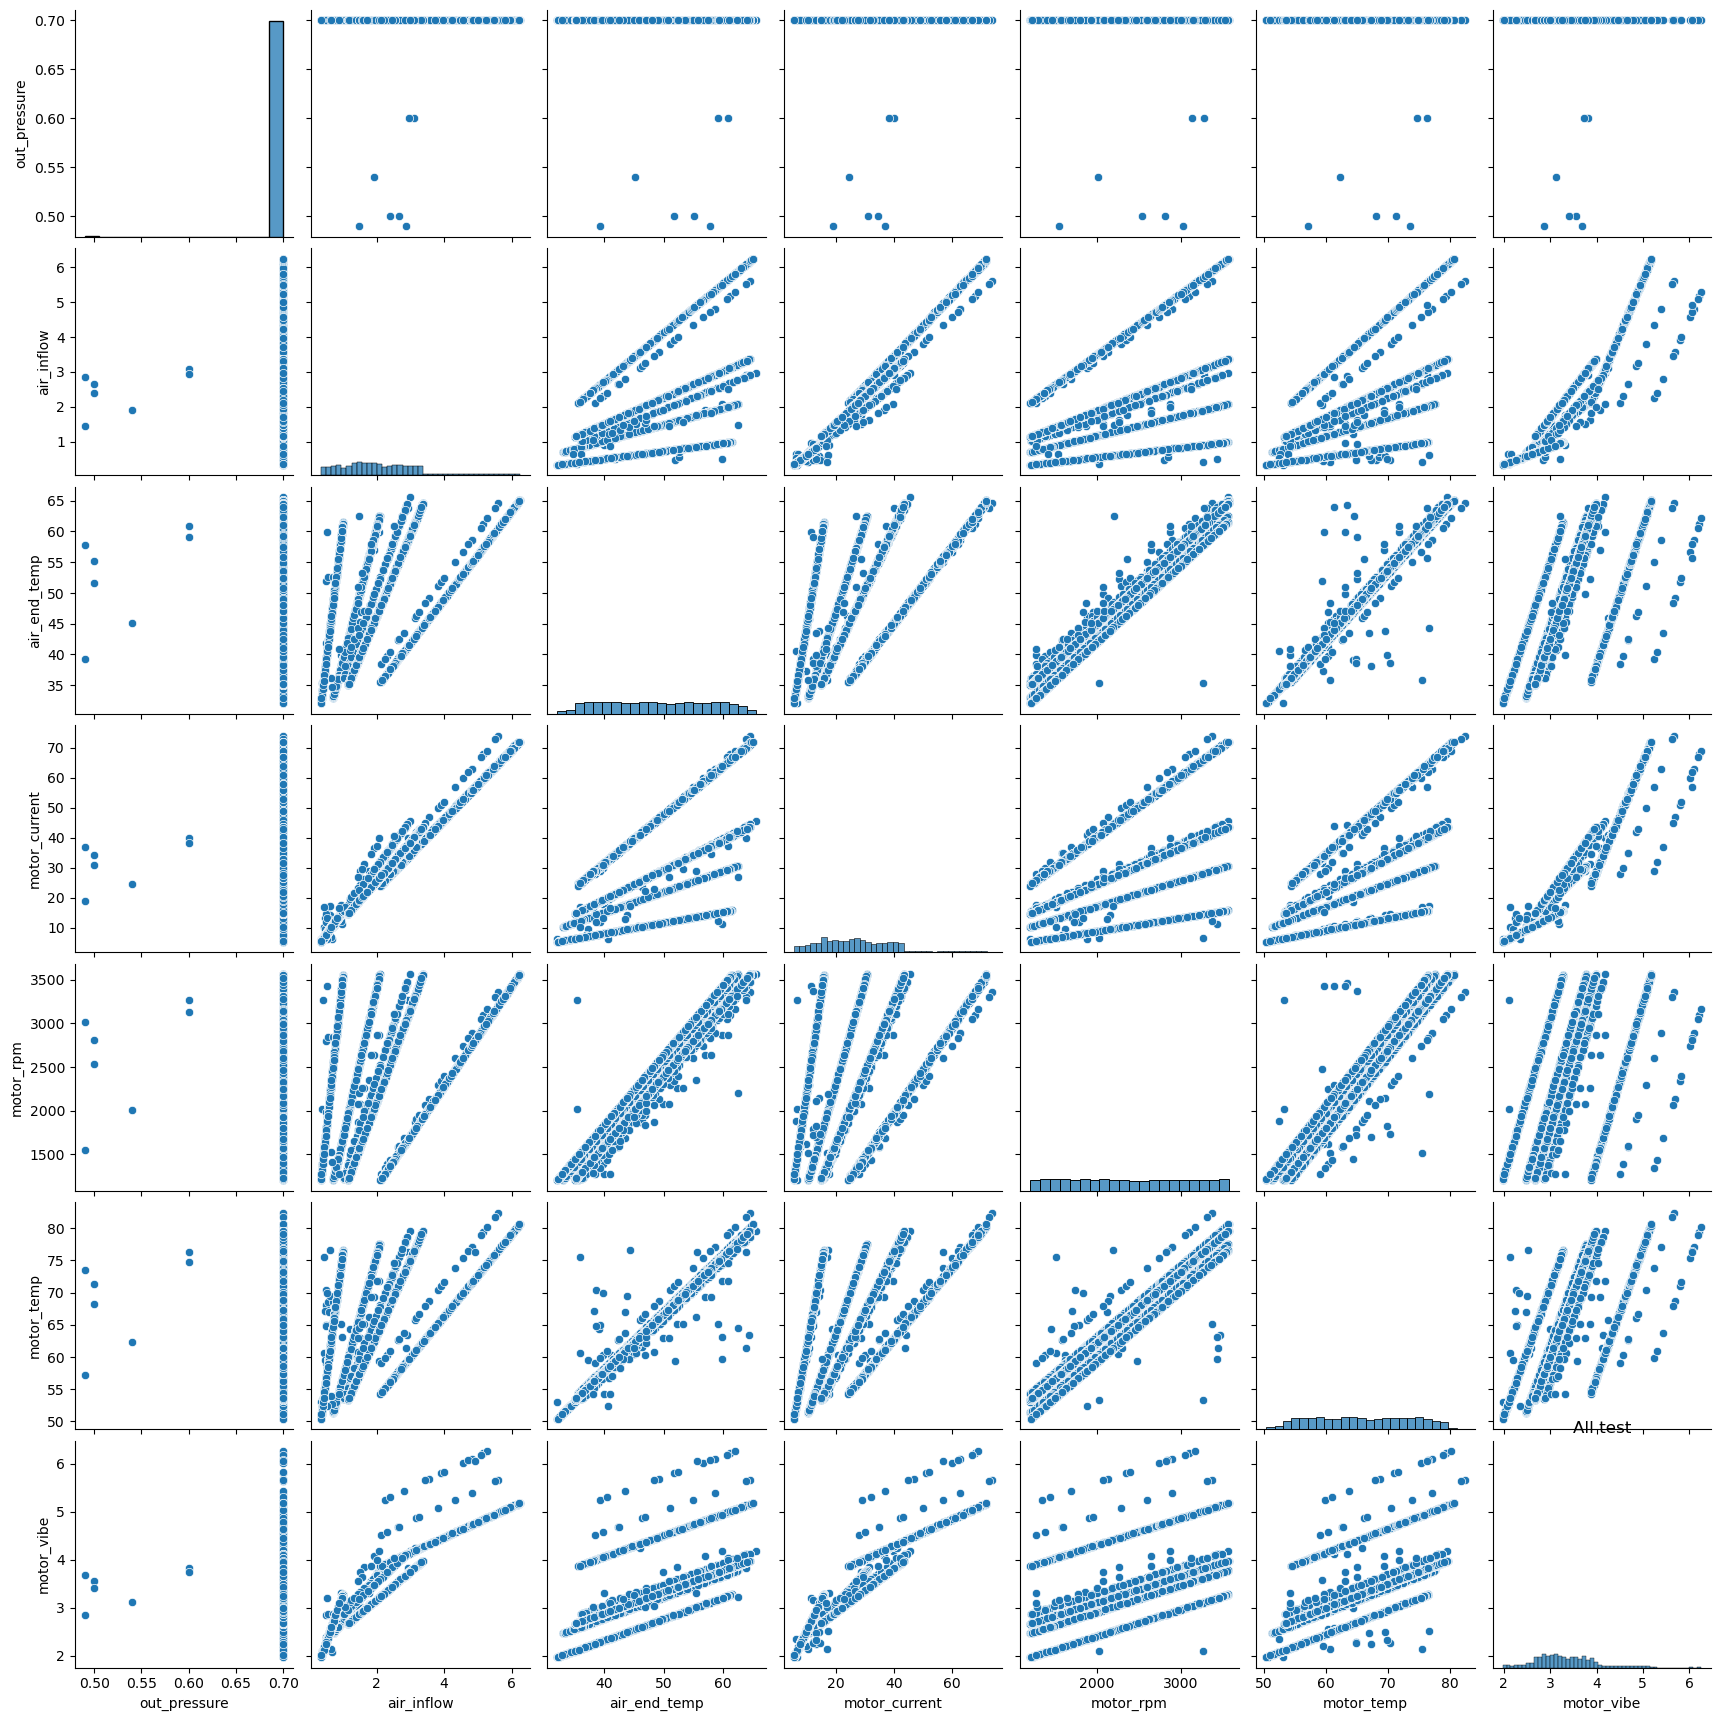

In [18]:
# train 전체
def pair(df, title):
    sns.pairplot(df.iloc[:,:-2])
    plt.title(title)
    plt.show()
    
pair(train_data, 'All train')
pair(test_data, 'All test')

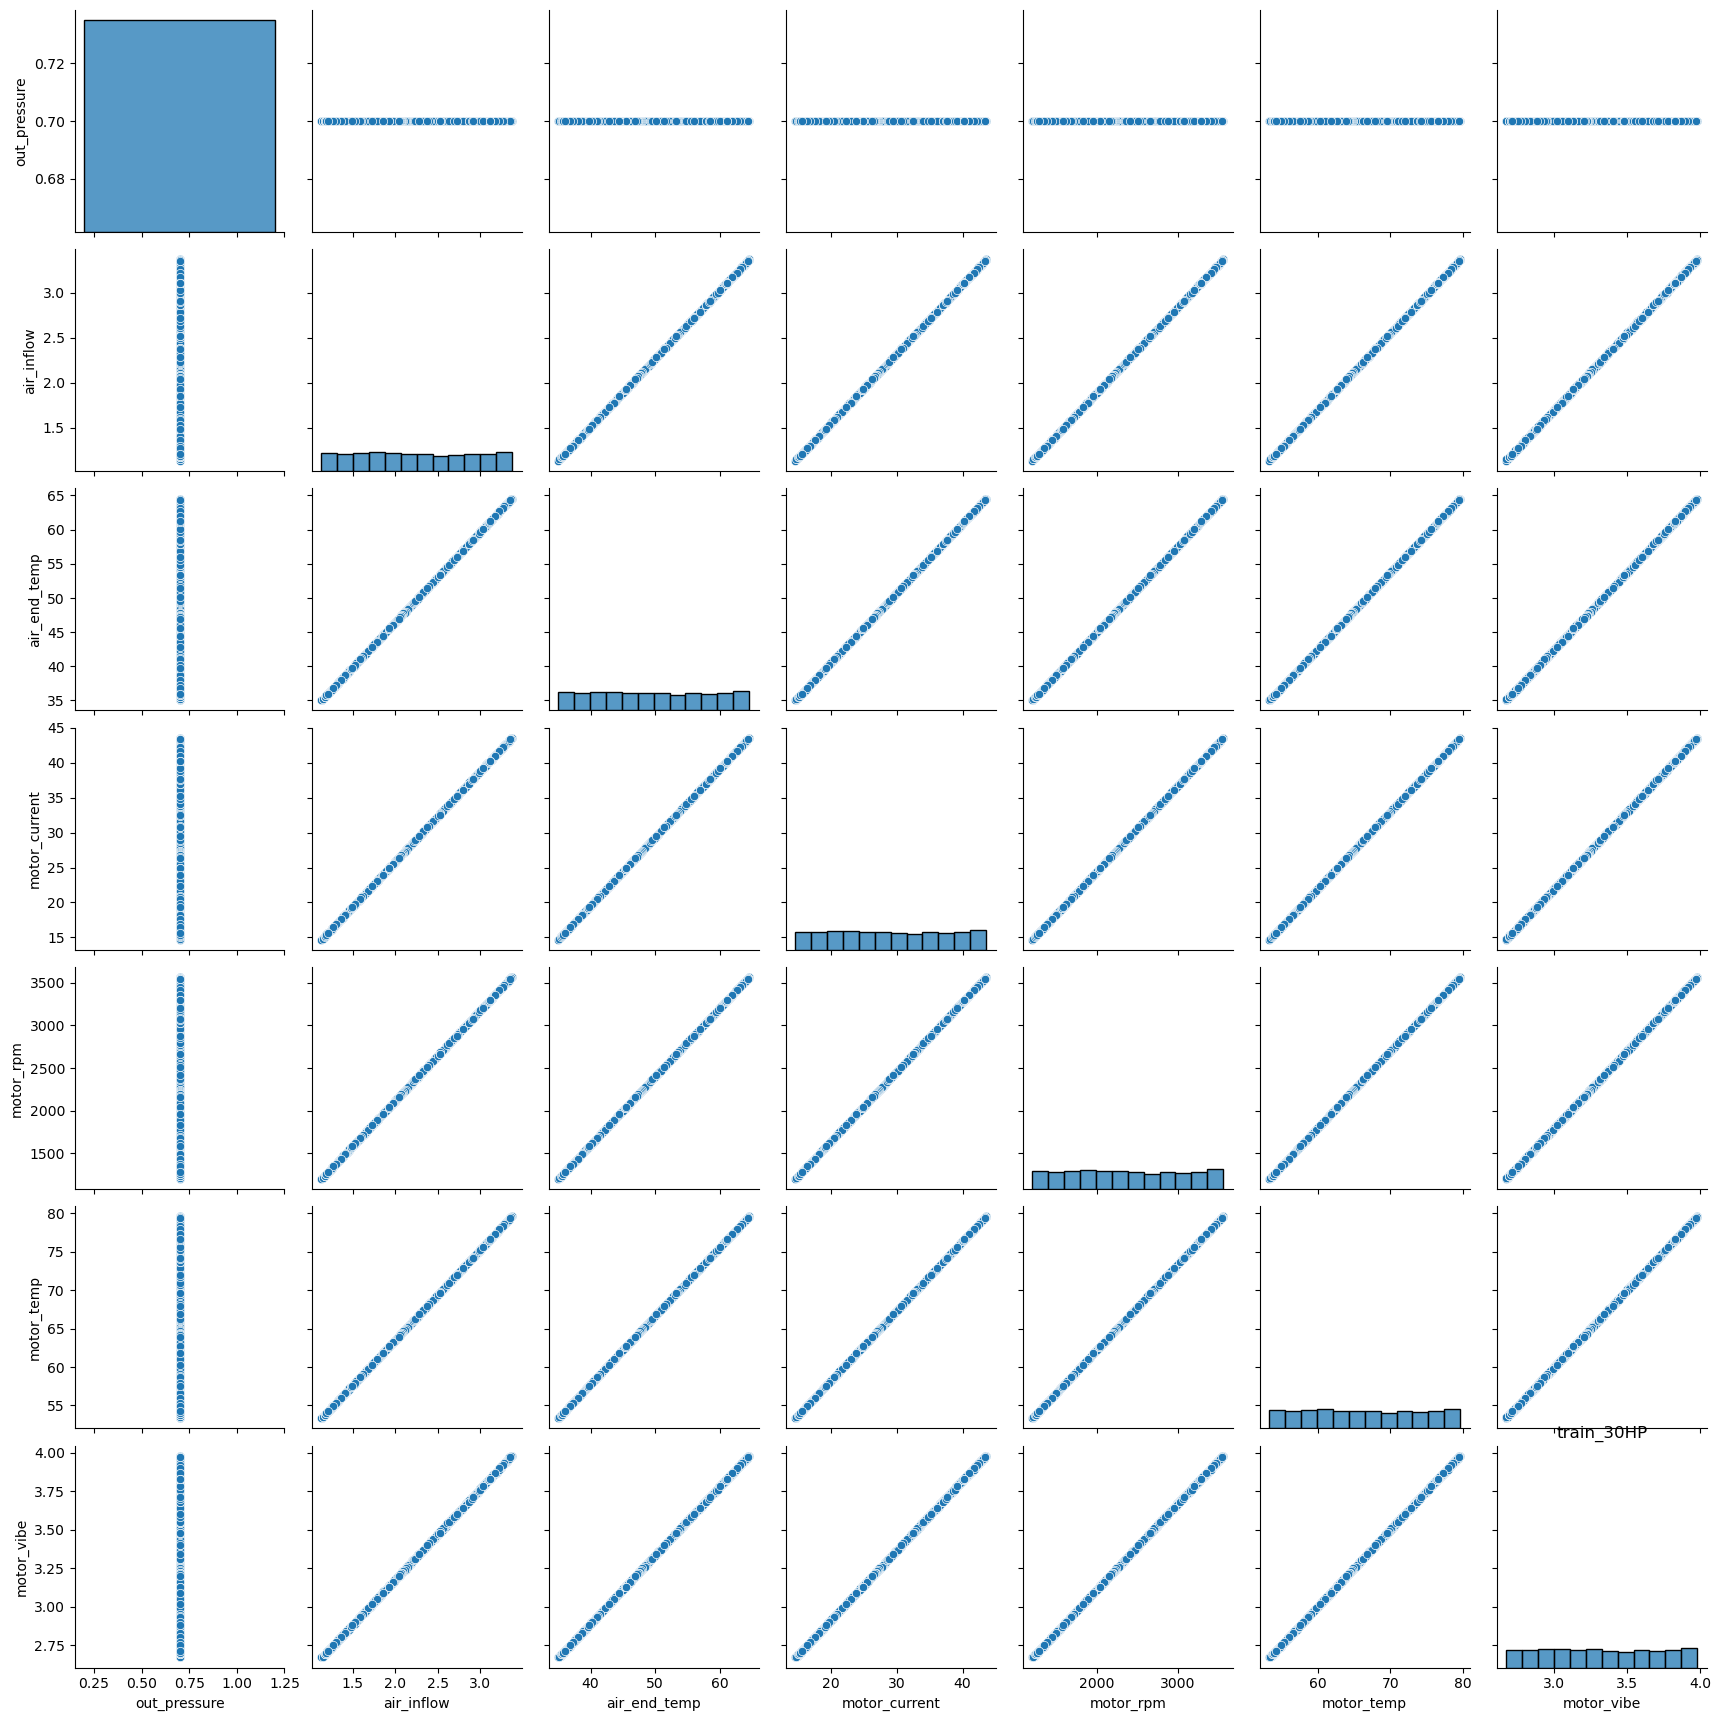

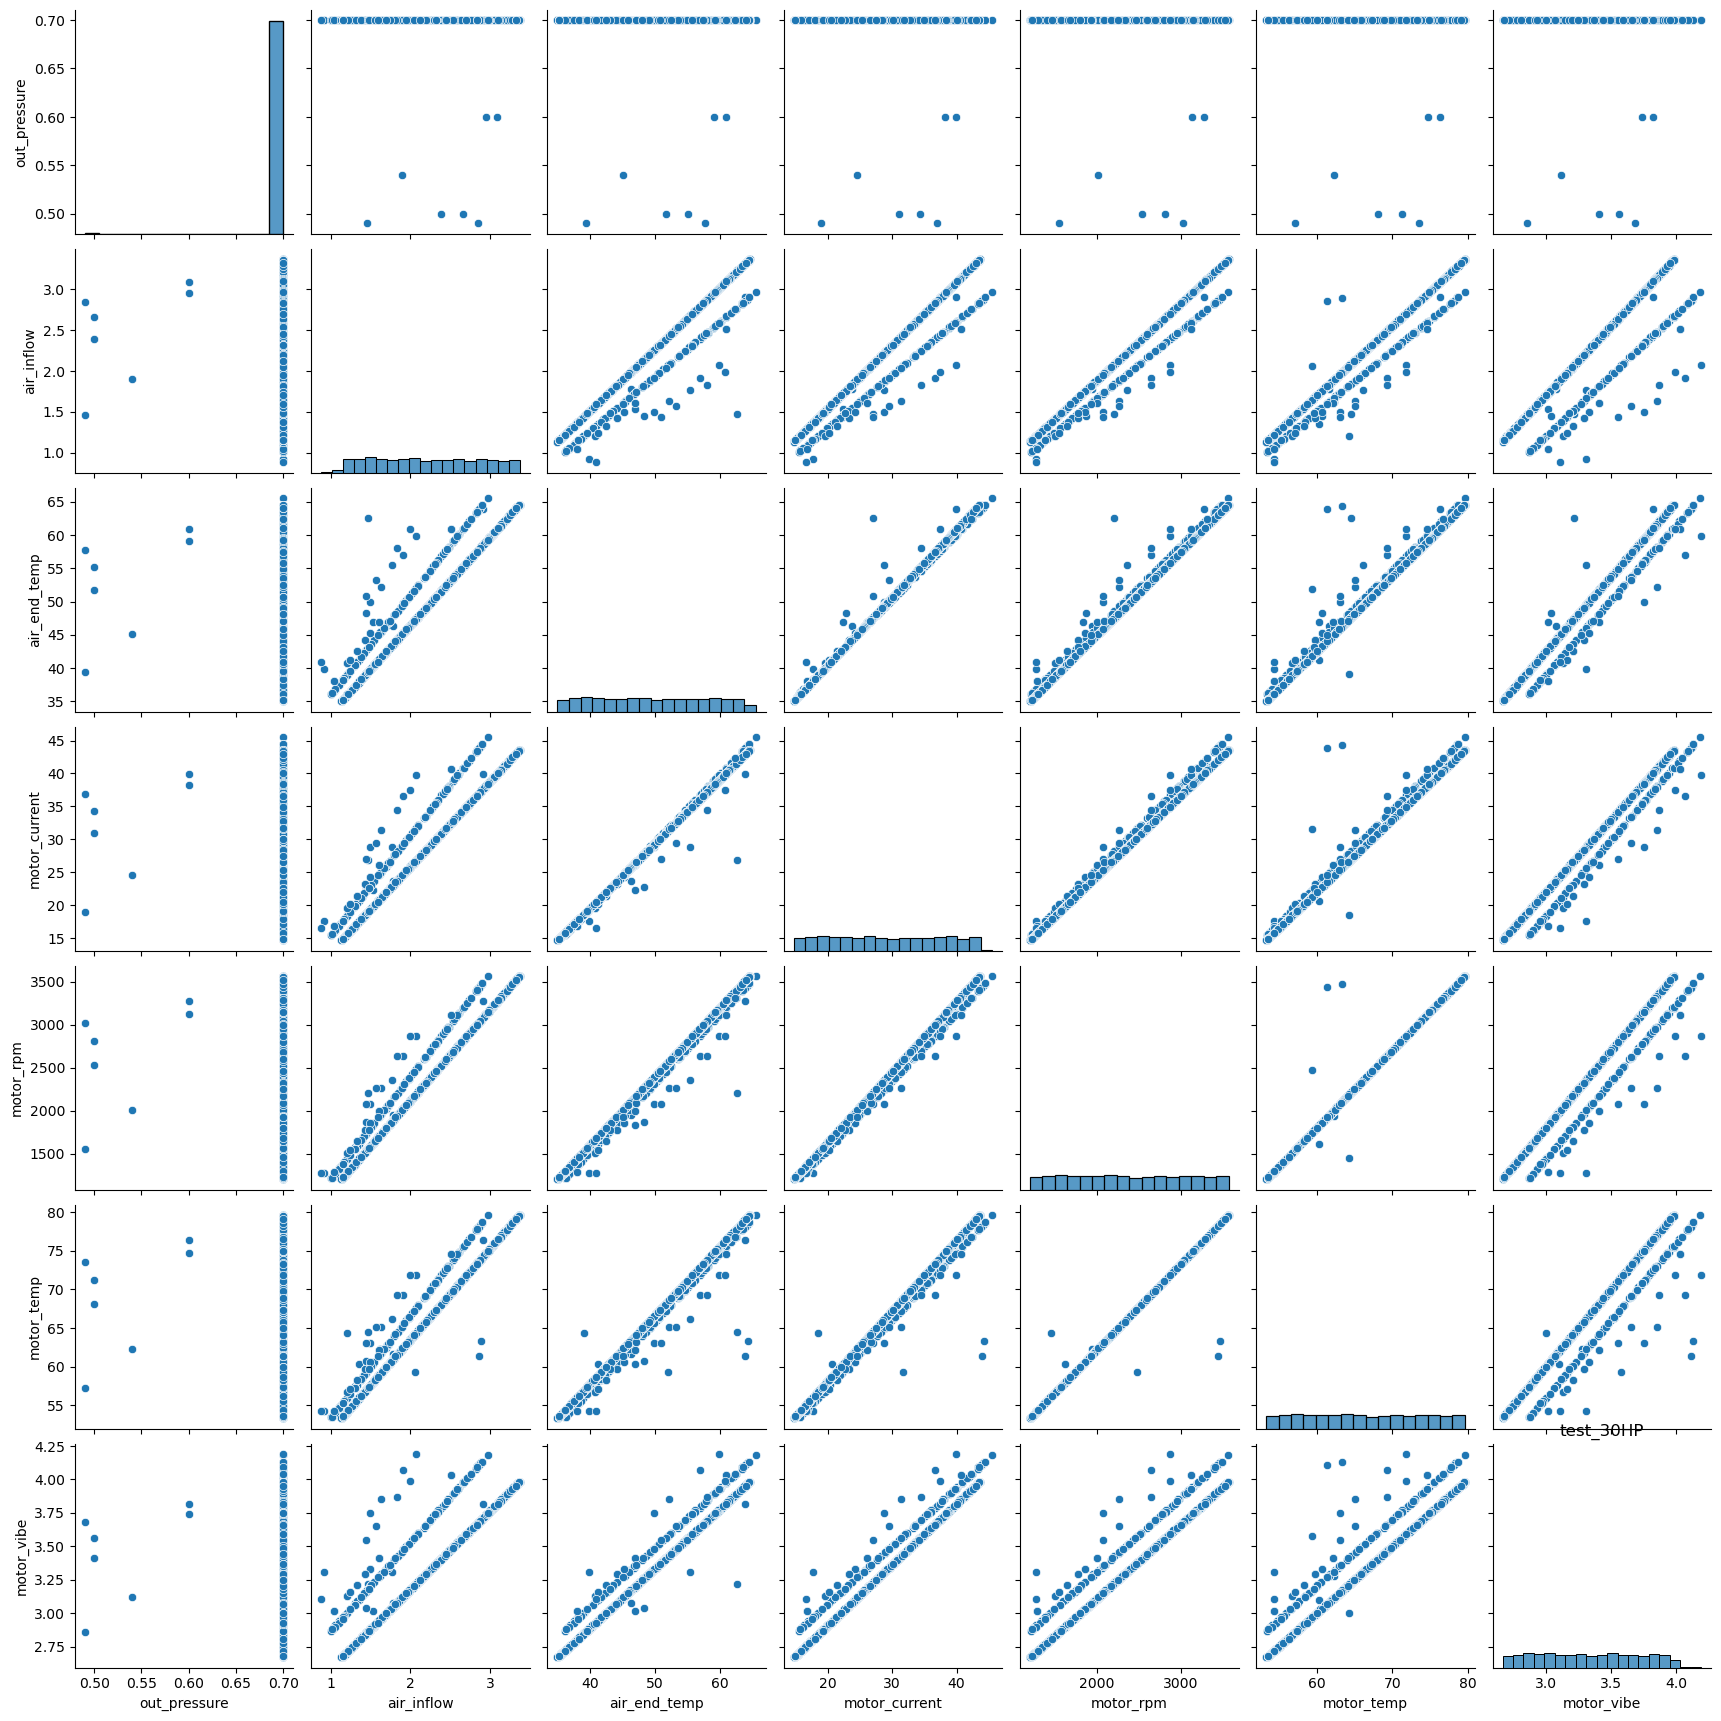

In [19]:
pair(train_30, 'train_30HP')
pair(test_30, 'test_30HP')

#### 상관계수 - 히트맵

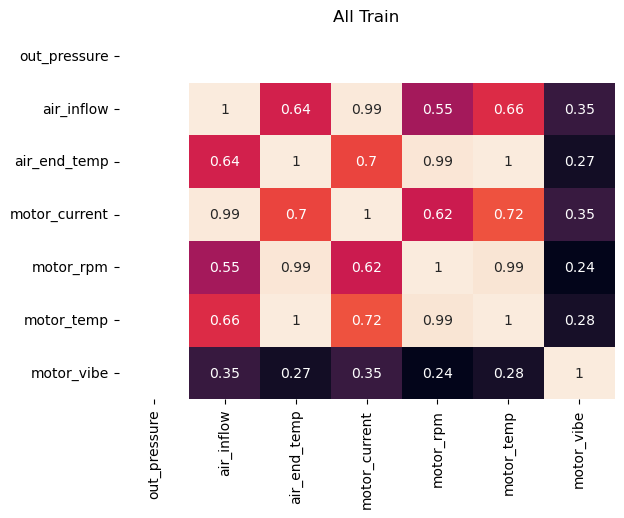

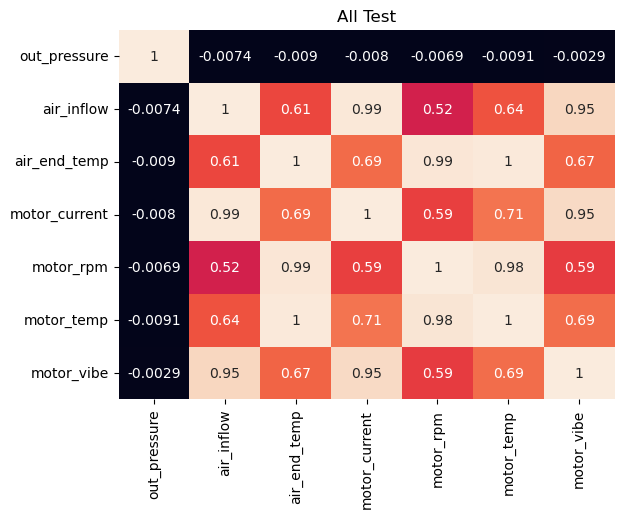

In [20]:
# 전체
def hmap(df, title):
    sns.heatmap(df.iloc[:,:-2].corr(), annot=True, fmt='.2g', cbar=False)
    plt.title(f"{title}")
    plt.show()
    
hmap(train_data, 'All Train')
hmap(test_data, 'All Test')

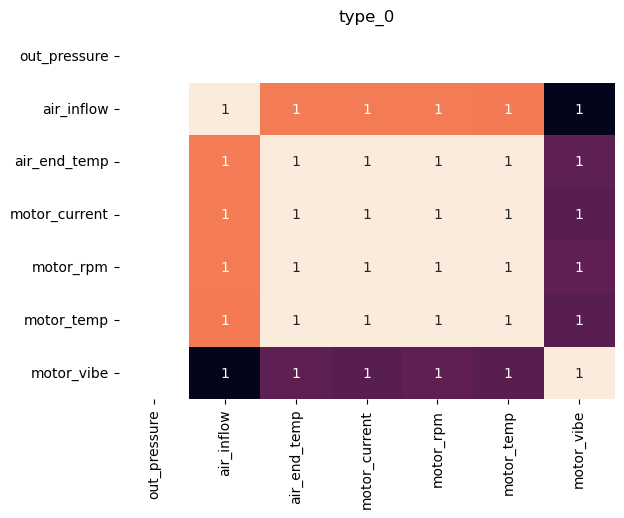

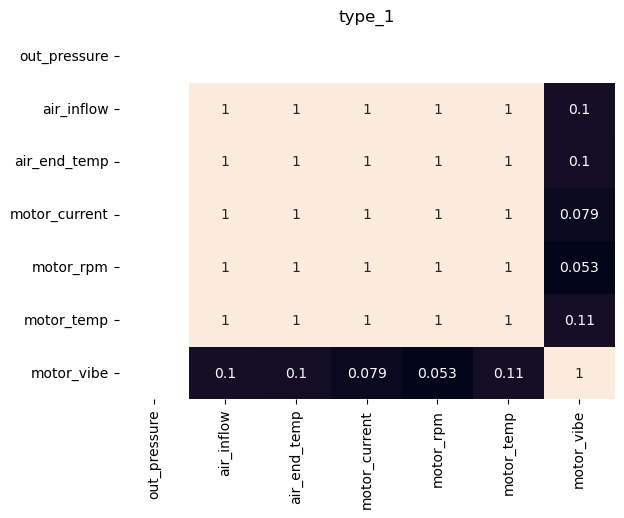

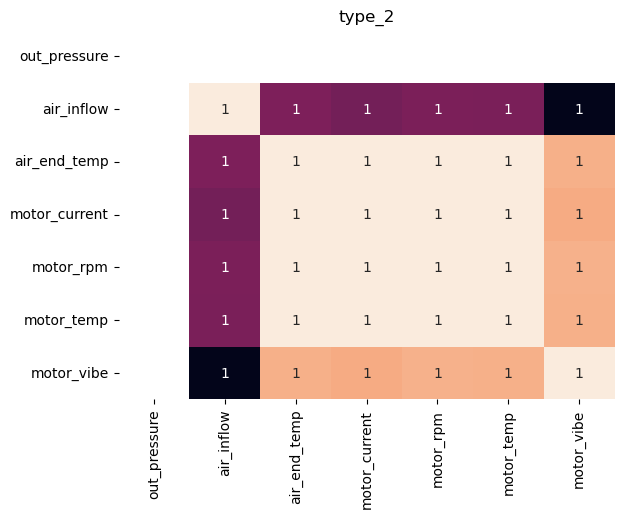

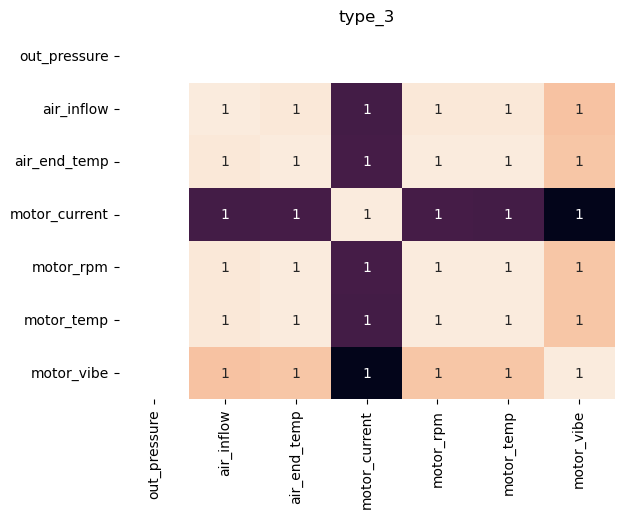

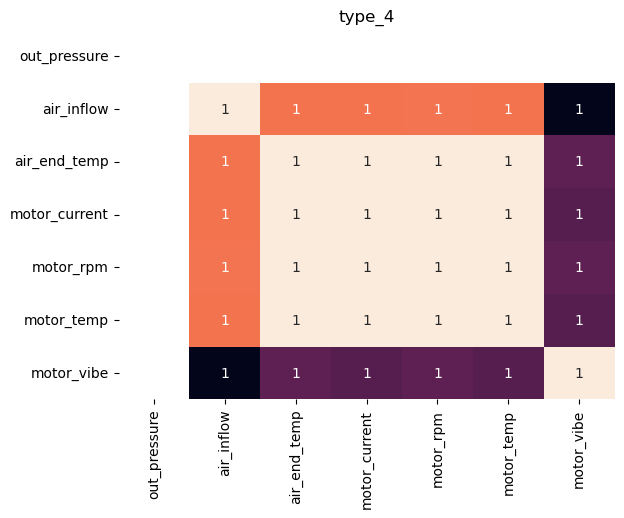

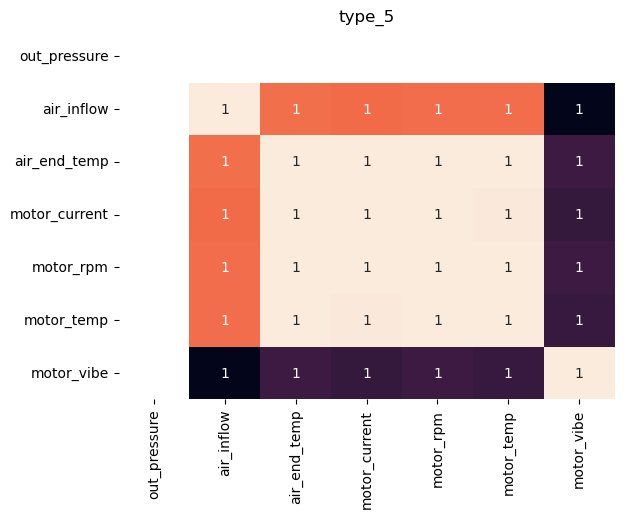

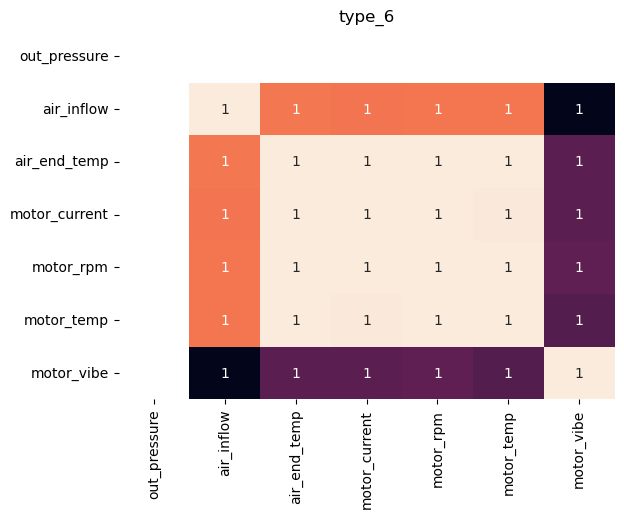

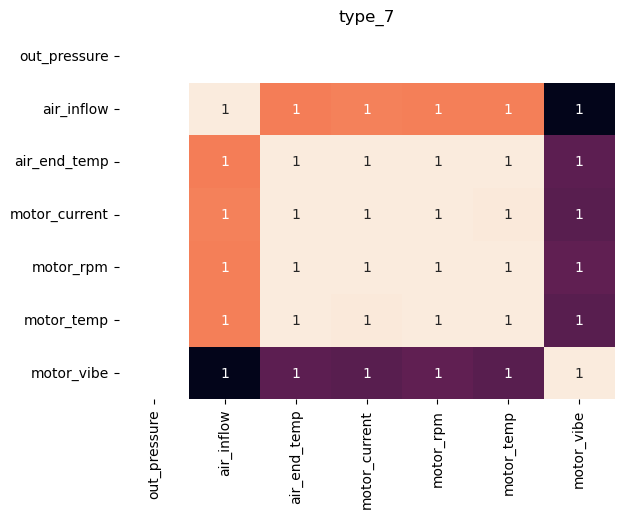

In [21]:
train_set = [train0, train1, train2, train3,
             train4, train5, train6, train7]
test_set = [test0, test1, test2, test3,
             test4, test5, test6, test7]

for i, df in enumerate(train_set):
    hmap(df, f'type_{i}')

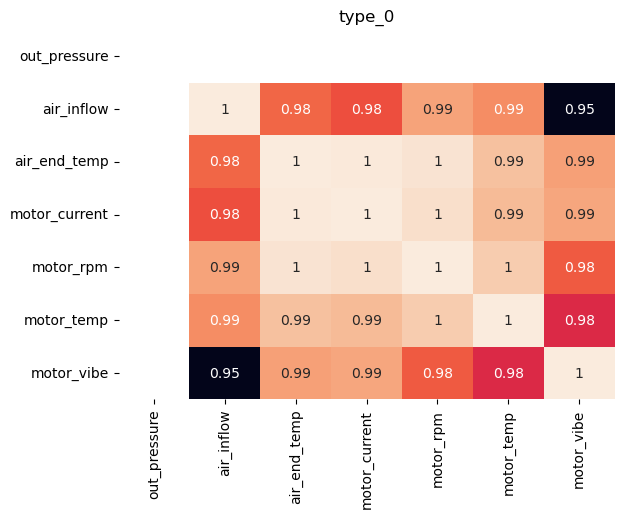

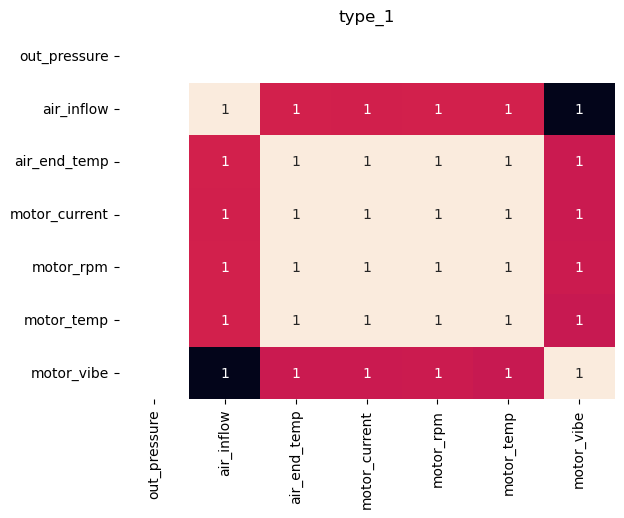

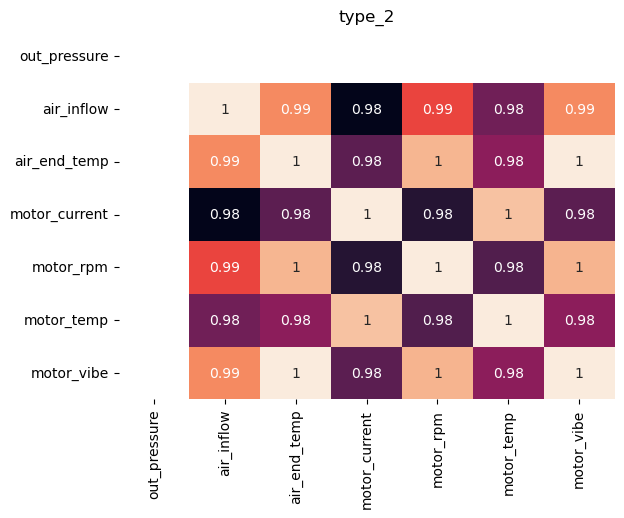

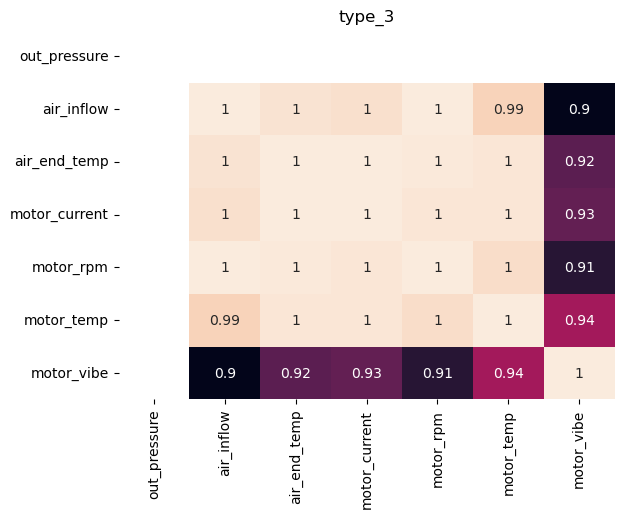

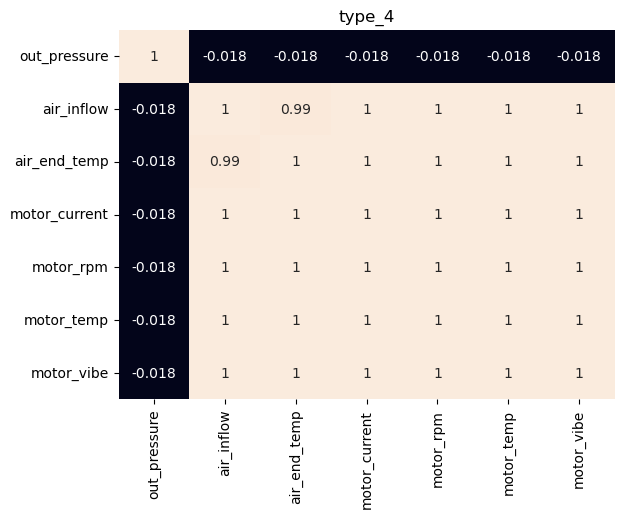

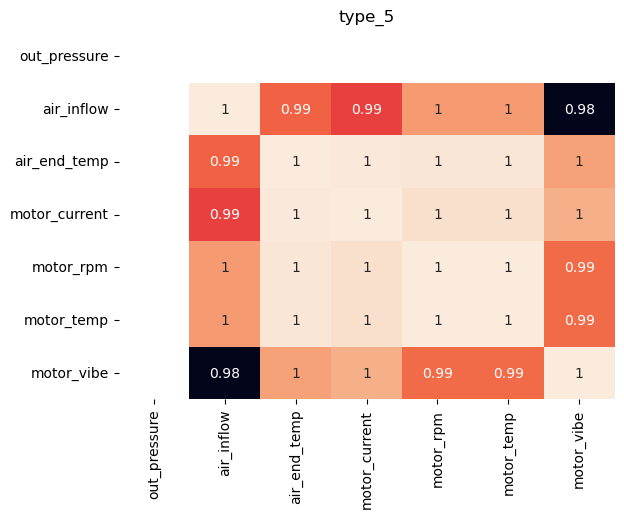

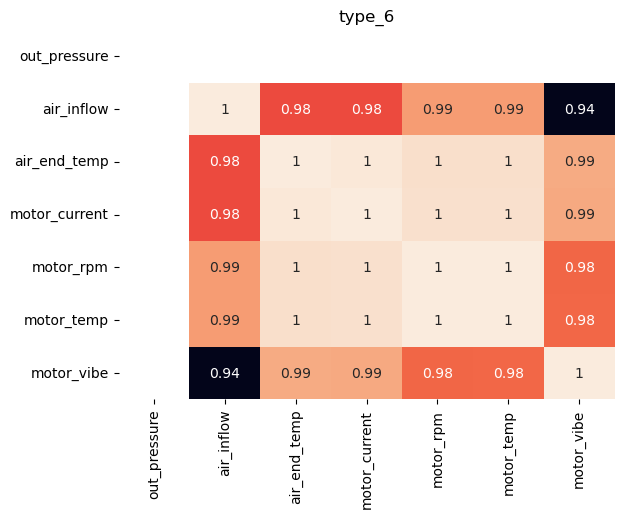

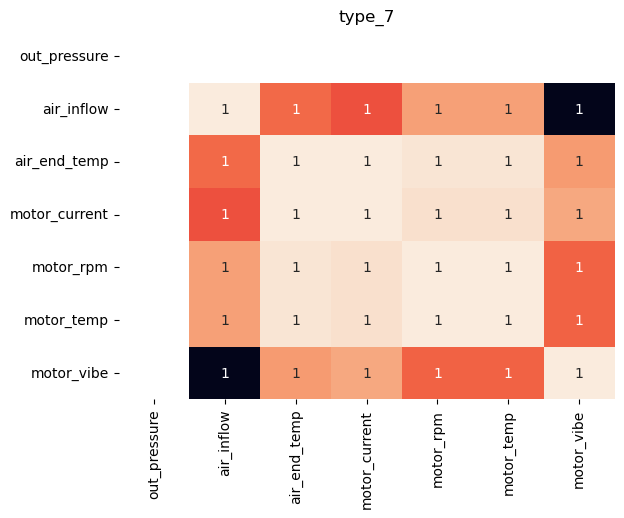

In [22]:
for i, df in enumerate(test_set):
    hmap(df, f'type_{i}')

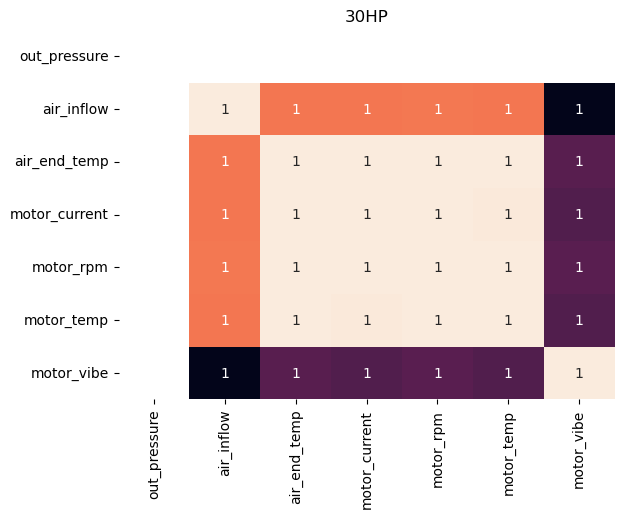

In [23]:
hmap(train_30, '30HP')

<h3> 정리 </h3>
1. 정상데이터의 독립변수들은 모두 서로 상관관계를 가짐. <br> 
2. 이상데이터는 이 상관성에서 벗어나는 것들. <br>
3. 그러므로 정상데이터의 feature들로부터 그래프를 얻어야한다?


## 추가 전처리

In [24]:
# motor_vibe 이상치 제거
outlier_idx = train_data[train_data.motor_vibe > 6].index

train_data = train_data.drop(index=outlier_idx)
train_data.reset_index(drop=True, inplace=True)

## 그래프 시각화하여 EDA

In [25]:
train_set = dict()
test_set = dict()
for hptype in [10, 20, 30, 50]:
    train_set[f'{hptype}HP'] = train_data[train_data.hp == hptype]
    test_set[f'{hptype}HP'] = test_data[test_data.hp == hptype]

In [26]:
train_set["10HP"]

out_pressure  air_inflow  air_end_temp  motor_current  motor_rpm  \
785            0.7        0.62         45.11          10.00     2249.0   
786            0.7        0.57         42.79           9.17     2063.0   
787            0.7        0.45         37.41           7.26     1633.0   
788            0.7        0.37         33.48           5.86     1318.0   
789            0.7        0.51         39.95           8.16     1836.0   
...            ...         ...           ...            ...        ...   
1146           0.7        0.68         47.55          10.86     2444.0   
1147           0.7        0.57         42.56           9.09     2045.0   
1148           0.7        0.80         53.11          12.84     2889.0   
1149           0.7        0.89         57.11          14.26     3209.0   
1150           0.7        0.39         34.65           6.28     1412.0   

      motor_temp  motor_vibe  type    hp  
785        61.99        2.55     2  10.0  
786        59.92        2.45     2  10.0  
787        55.14        2.21     2  10.0  
788        51.64        2.03     2  10.0  
789        57.40        2.32     2  10.0  
...          ...         ...   ...   ...  
1146       64.16        2.66     2  10.0  
1147       59.72        2.44     2  10.0  
1148       69.10        2.91     2  10.0  
1149       72.66        3.08     2  10.0  
1150       52.69        2.08     2  10.0  

[366 rows x 9 columns]

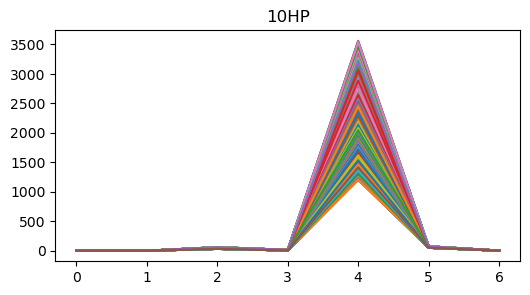

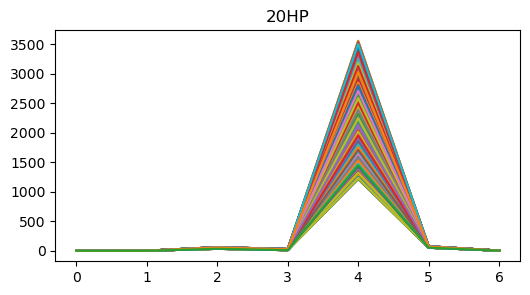

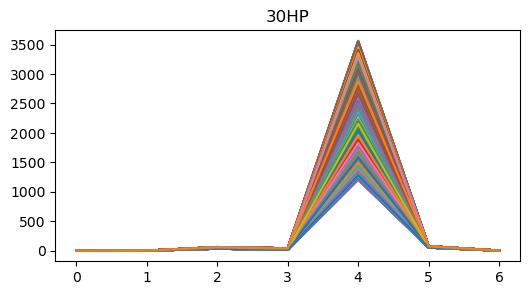

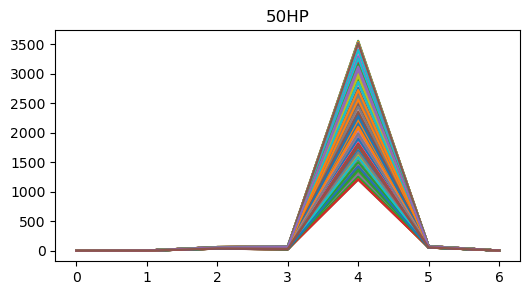

In [27]:
def plot_graph(df, title):
    x = np.arange(len(df.columns))
    plt.figure(figsize=(6,3))
    for i in range(len(df)):
        plt.plot(x, df.iloc[i,:])
    plt.title(f"{title}")
    plt.show()

for key, val_df in train_set.items():
    plot_graph(val_df.iloc[:,:-2], f'{key}')

<h3> 정리 </h3>
- 스케일링 필요

### 스케일링


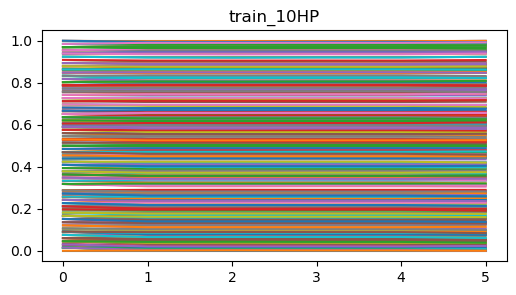

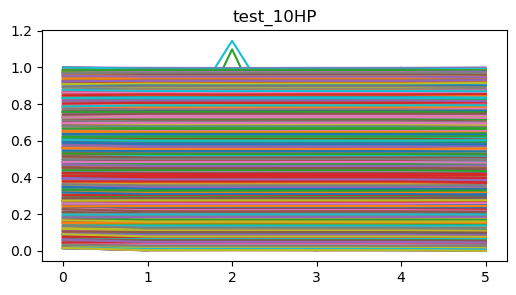

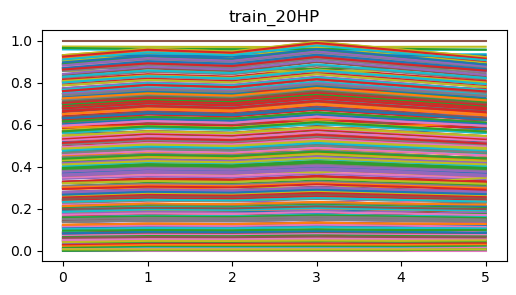

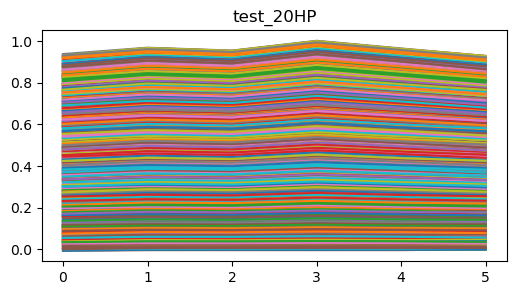

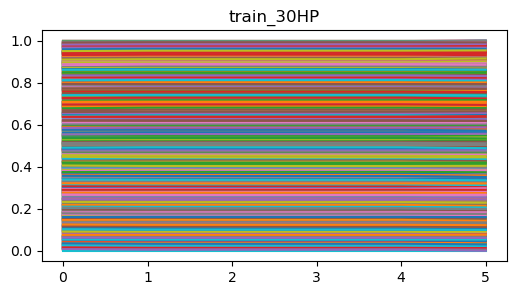

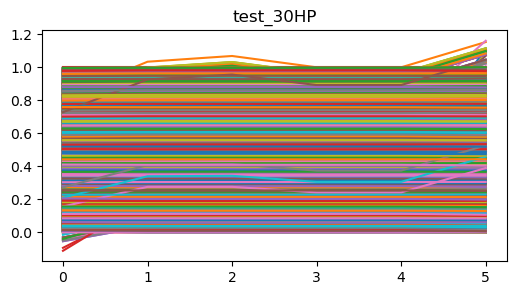

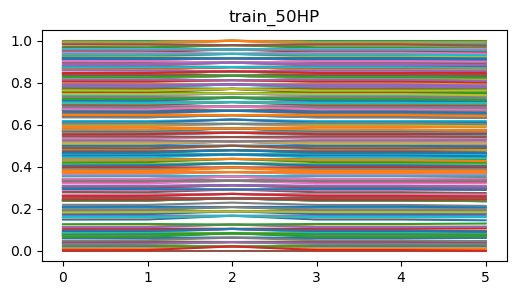

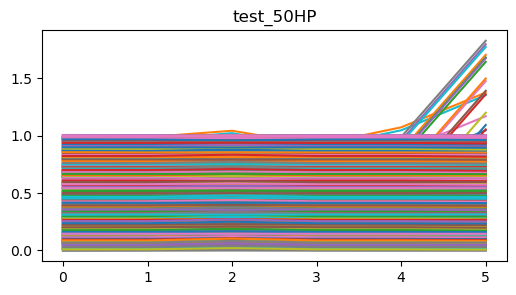

In [30]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def scaling(train, test, scaler):
    scaled_train = pd.DataFrame(scaler.fit_transform(train), index=train.index, columns=train.columns)
    scaled_test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
    return scaled_train, scaled_test

scaled_train = dict()
scaled_test = dict()
for hp in ["10HP", "20HP", "30HP", "50HP"]:
    scaled_train[hp], scaled_test[hp] = scaling(train_set[hp].iloc[:,1:-2], test_set[hp].iloc[:,1:-2],
                                                MinMaxScaler())
    plot_graph(scaled_train[hp], f'train_{hp}')
    plot_graph(scaled_test[hp], f'test_{hp}')


<h3> 정리 </h3>

각 구간마다 기울기를 계산하여 새로운 데이터프레임 생성.


In [31]:
scaled_train["10HP"]

air_inflow  air_end_temp  motor_current  motor_rpm  motor_temp  \
785     0.439394      0.443240       0.443810   0.443456    0.443385   
786     0.363636      0.364622       0.364762   0.364676    0.364468   
787     0.181818      0.182311       0.182857   0.182550    0.182234   
788     0.060606      0.049136       0.049524   0.049132    0.048799   
789     0.272727      0.268384       0.268571   0.268530    0.268395   
...          ...           ...            ...        ...         ...   
1146    0.530303      0.525923       0.525714   0.526048    0.526115   
1147    0.363636      0.356828       0.357143   0.357052    0.356843   
1148    0.712121      0.714334       0.714286   0.714528    0.714449   
1149    0.848485      0.849881       0.849524   0.850064    0.850172   
1150    0.090909      0.088783       0.089524   0.088945    0.088830   

      motor_vibe  
785     0.442748  
786     0.366412  
787     0.183206  
788     0.045802  
789     0.267176  
...          ...  
1146    0.526718  
1147    0.358779  
1148    0.717557  
1149    0.847328  
1150    0.083969  

[366 rows x 6 columns]

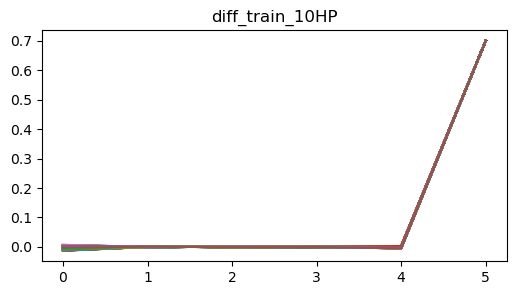

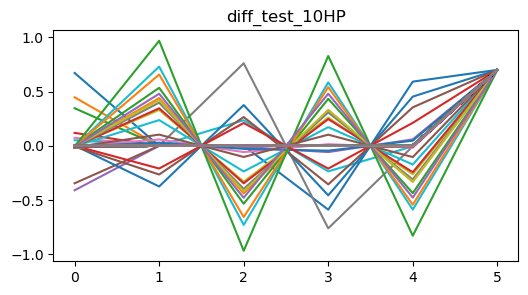

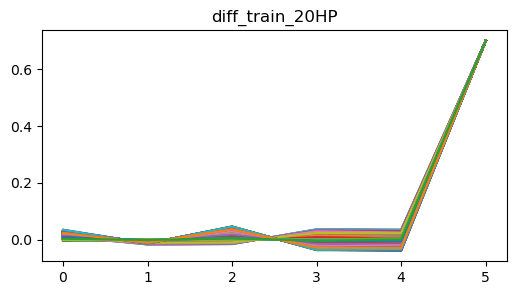

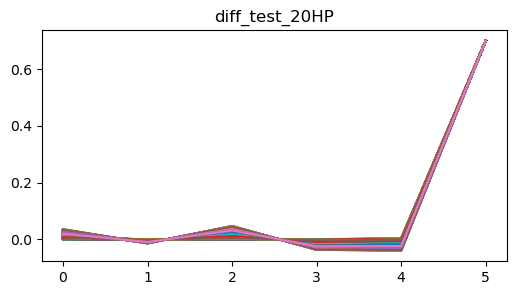

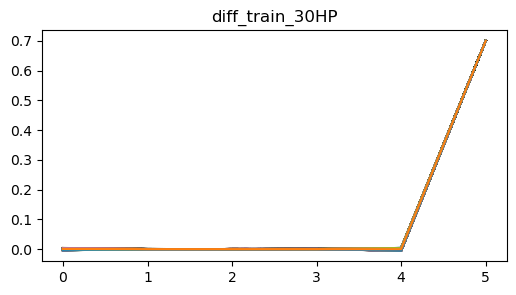

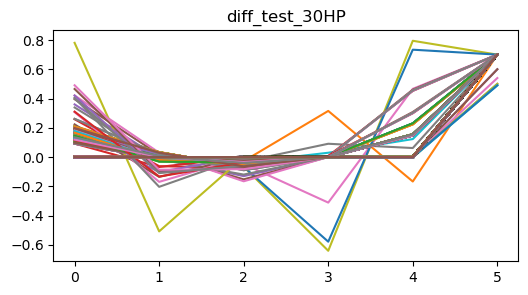

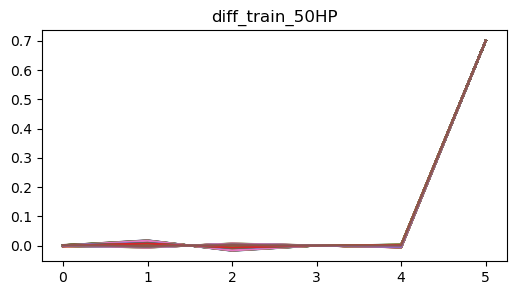

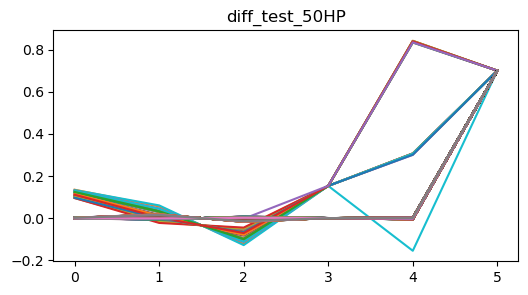

In [32]:
# 각 행에 대한 기울기 계산
def derivative(df):
    deriv_df = pd.DataFrame()
    for i in range(len(df.columns)-1):
        diff = df.apply(lambda x: x[i+1] - x[i], axis=1)
        deriv_df[f"diff{i+1}"] = diff
    return deriv_df

deriv_train = dict()
deriv_test = dict()
for hp in scaled_train.keys():
    deriv_train[hp] = derivative(scaled_train[hp])
    deriv_test[hp] = derivative(scaled_test[hp])

for hp in deriv_train.keys():
    deriv_train[hp]["out_pressure"] = train_data.out_pressure
    deriv_test[hp]["out_pressure"] = test_data.out_pressure
    plot_graph(deriv_train[hp], f"diff_train_{hp}")
    plot_graph(deriv_test[hp], f"diff_test_{hp}")

In [33]:
all_type_deriv_train = pd.concat([deriv_train["10HP"],
                                  deriv_train["20HP"],
                                  deriv_train["30HP"],
                                  deriv_train["50HP"]])

all_type_deriv_test = pd.concat([deriv_test["10HP"],
                                  deriv_test["20HP"],
                                  deriv_test["30HP"],
                                  deriv_test["50HP"]])

all_type_deriv_train.sort_index(inplace=True)
all_type_deriv_test.sort_index(inplace=True)

In [34]:
# 기울기 데이터프레임에 대해 pca로 시각화
from sklearn.decomposition import PCA

def pca(train, test, n = 2):
    pca = PCA(n_components=n, random_state=1234)
    pca_train = pca.fit_transform(train)
    pca_test = pca.transform(test)
    if n == 2:
        pca_train = pd.DataFrame(pca_train, index=train.index, columns=['x','y'])
        pca_test = pd.DataFrame(pca_test, index=test.index, columns=['x','y'])
    elif n == 3:
        pca_train = pd.DataFrame(pca_train, index=train.index, columns=['x','y','z'])
        pca_test = pd.DataFrame(pca_test, index=test.index, columns=['x','y','z'])
    else:
        pass
    return pca_train, pca_test

def plot_pca(train, test, n = 2):
    fig = plt.figure(figsize=(15,10))
    if n == 2:
        ax = fig.add_subplot(111)
        ax.scatter(train['x'], train['y'], s=10, color='b', label='train')
        ax.scatter(test['x'], test['y'], s=1, color='r', label='test')
    elif n == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(train['x'], train['y'], train['z'], s=10, color='b', alpha=0.5, label='train')
        ax.scatter(test['x'], test['y'], test['z'], s=1, color='r', alpha=0.5, label='test')
        ax.view_init(elev=15., azim=150)
        
    plt.title(f"PCA {n}D", fontsize=15)
    plt.legend(fontsize=7)
    plt.show()

In [35]:
def plot_result(normal, abnomal, n = 2):
    fig = plt.figure(figsize=(15,10))
    if n == 2:
        ax = fig.add_subplot(111)
        ax.scatter(normal['x'], normal['y'], s=10, color='b', label='normal')
        ax.scatter(abnomal['x'], abnomal['y'], s=1, color='r', label='abnormal')
    elif n == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(normal['x'], normal['y'], normal['z'], s=10, color='b', alpha=0.5, label='normal')
        ax.scatter(abnomal['x'], abnomal['y'], abnomal['z'], s=5, color='r', alpha=0.5, label='abnormal')
        ax.view_init(elev=15., azim=80)
        
    plt.title(f"Result", fontsize=15)
    plt.legend(fontsize=7)
    plt.show()

In [38]:
# 제출파일 생성
def make_submission(label, filename):
    submission = pd.read_csv("./answer_sample.csv")
    submission.label = label
    submission.to_csv(f"./submission/{filename}.csv", index=False)

## 모델링

/home/seon/miniconda3/envs/aifactory/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (10000) is greater than the total number of samples (2447). max_samples will be set to n_samples for estimation.
  warn(
/home/seon/miniconda3/envs/aifactory/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Counter({0: 7044, 1: 345})


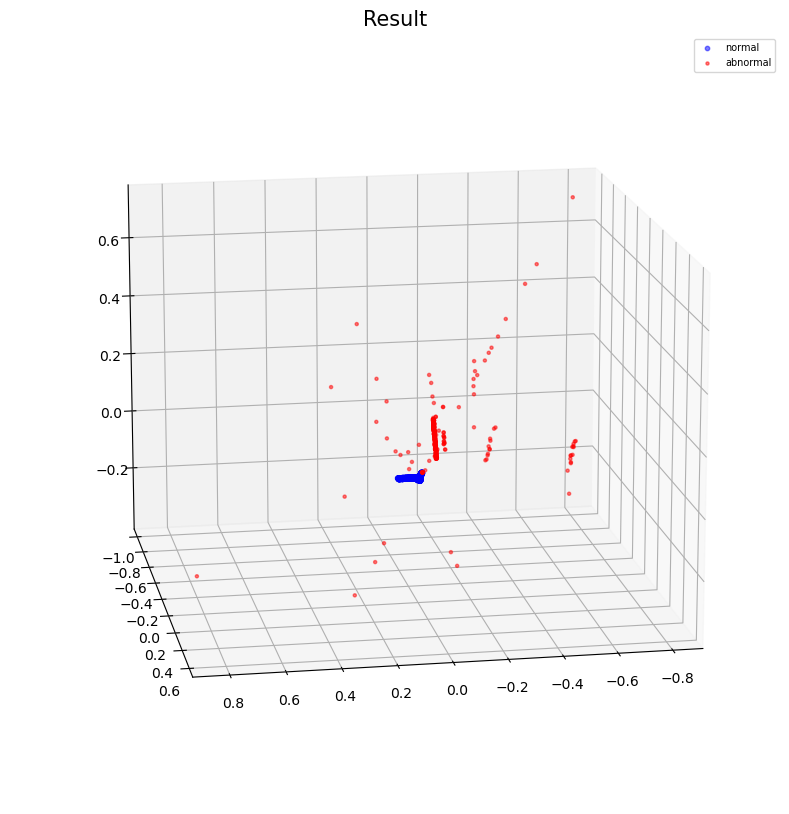

In [36]:
# IF모델
from sklearn.ensemble import IsolationForest

pca_train, pca_test = pca(all_type_deriv_train,all_type_deriv_test, 3)

ifmodel = IsolationForest(max_samples=10000, contamination=0.0057, random_state=1234)
train = pca_train.copy()
test = pca_test.copy()

ifmodel.fit(train)
pred = np.where(ifmodel.predict(test)==1, 0, 1)

print(Counter(pred))

test["label"] = pred

normal_test = test[test.label == 0]
abnormal_test = test[test.label == 1]

plot_result(normal_test, abnormal_test, 3)

In [69]:
make_submission(pred, "test_outpressure_origin")

Counter({0: 7042, 1: 347})


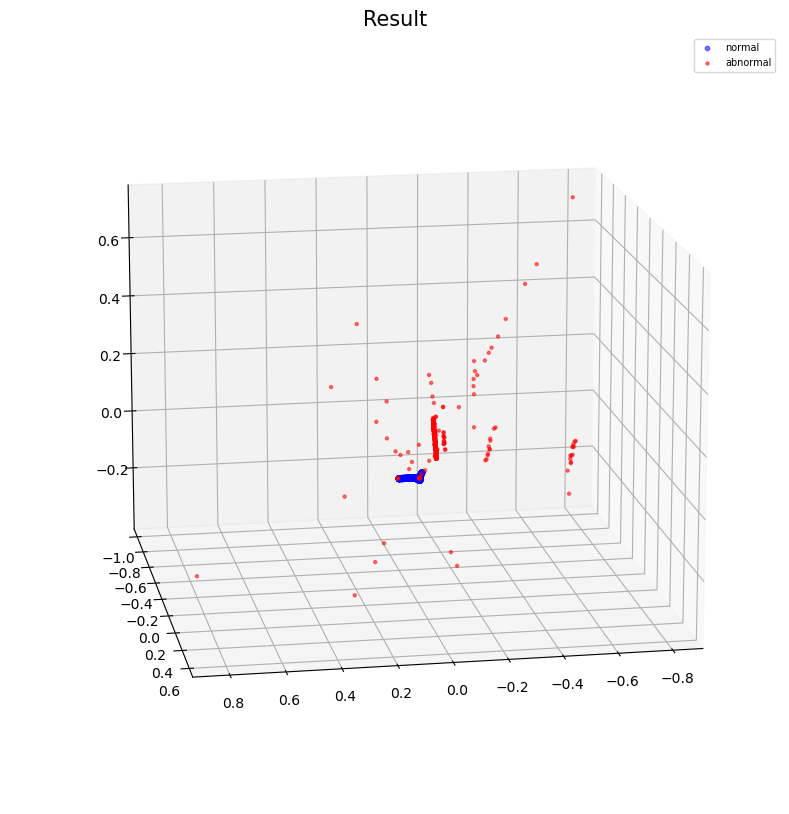

In [306]:
from sklearn.svm import OneClassSVM

# 모델 1: model = OneClassSVM(gamma=1, kernel='rbf', nu=0.006)
# 모델 2: model = OneClassSVM(gamma=10, kernel='rbf', nu=0.005)
# 모델 3: model = OneClassSVM(gamma=100, kernel='rbf', nu=0.001)
# 모델 4: 
model = OneClassSVM(gamma=100, kernel='rbf', nu=0.000009)
model.fit(all_type_deriv_train)

pred = np.where(model.predict(all_type_deriv_test) == 1, 0, 1)

train, test = pca(all_type_deriv_train,all_type_deriv_test, 3)

test["label"] = pred

normal_test = test[test.label == 0]
abnormal_test = test[test.label == 1]
print(Counter(pred))
plot_result(normal_test, abnormal_test, 3)

In [123]:
make_submission(pred, "ocsvm_04111003")

# 하드보팅 테스트
- 몇가지 케이스에 대해서 일단 테스트 해봄

Counter({0: 7053, 1: 336})


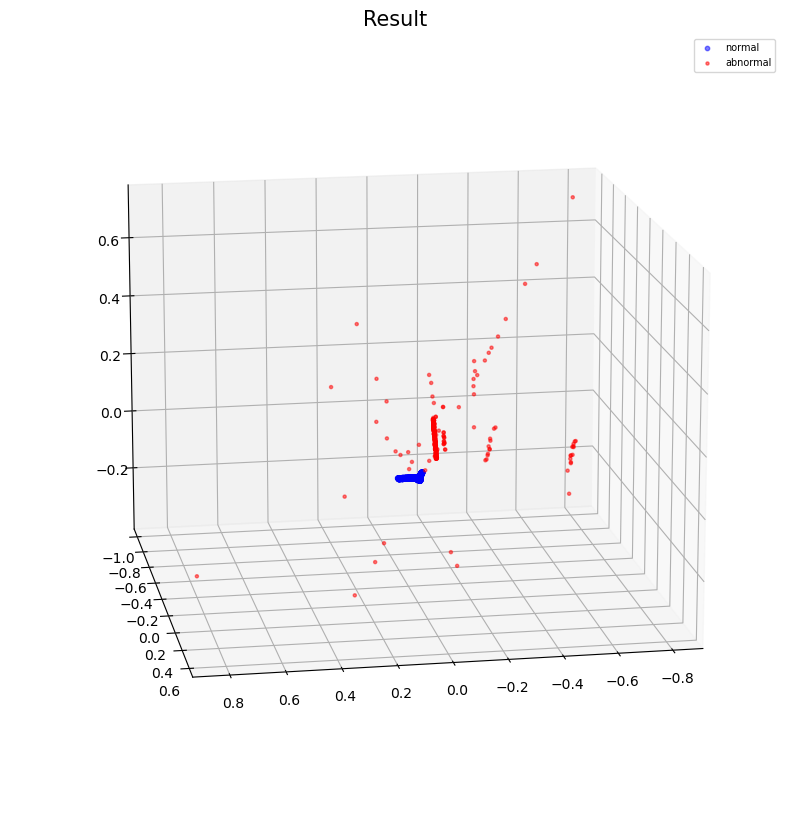

In [249]:
# 과반수 이상만 ok
result1 = pd.read_csv("./submission/new_AutoEncoder_04071526(0.959).csv")
result2 = pd.read_csv("./submission/isolation_04101607.csv")
#result3 = pd.read_csv("./submission/AutoEncoder_512_4_04080212.csv")

def voting(*results):
    '''
    results : 결과가 담긴 데이터프레임 리스트
    마지막 요소는 threshold
    '''
    voting = pd.Series(0, index=results[0].index)
    for result in results[:-1]:
        voting += result.label
    voting = np.where(voting >= results[-1], 1, 0)
    return voting

new_label = voting(result1, result2, 2)

print(Counter(new_label))
temp = pca_test.copy()
temp["label"] = new_label
temp_normal = temp[temp.label == 0]
temp_abnormal = temp[temp.label == 1]
plot_result(temp_normal, temp_abnormal, 3)

In [250]:
make_submission(new_label, "voting_ae_if_04111016")

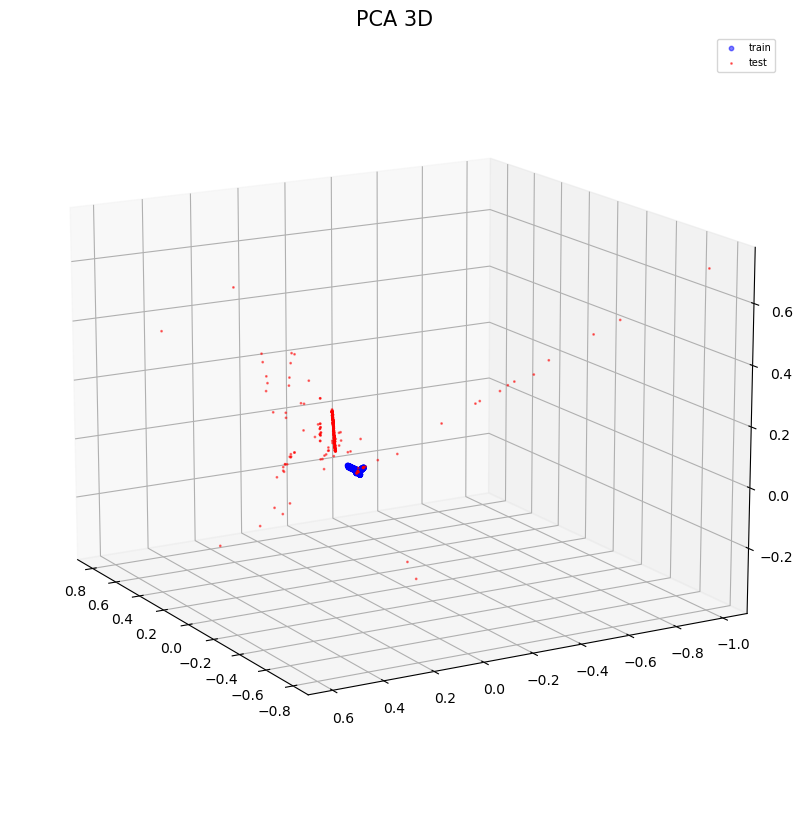

In [232]:
# result 라벨에 대한 PCA 그래프
temp = pca_test.copy()
temp["label"] = new_label
temp_normal = temp[temp.label == 0]
temp_abnormal = temp[temp.label == 1]

plot_pca(temp_normal, temp_abnormal, 3)